# Airline On-time Performance 2006

In this project, we will be analyzing airline performance provided from [kaggle](https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=1993.csv). It is a dataset from the **Data Expo 2009: Airline On Time Data**.

Objectives:
---
The objective of this project is:
- Identify temporal patterns in flight delays and cancellations (hourly, daily, monthly).
- Examine the frequency and severity of different delay causes (e.g., weather, carrier, NAS).
- Compare airline and airport performance based on cancellation and delay rates.
- Highlight problematic routes and assess contributing factors.
- Provide evidence-based recommendations to reduce disruptions and improve scheduling efficiency.

The dataset provided in the website covers flight details from year 1987 - 2008. However, in this project we will be focusing on the year **2006**. <br>
Thus, the total number of datasets that will be included as part of the analysis is the `airports.csv`, `carriers.csv`, `plane.csv`, and the `2006.csv` (table renamed to `data`). Details on each dataset will be provided as below; 

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| Year                  | 1987–2008                                                                   |int          |
| Month                 | 12–Jan                                                                      |string       |
| DayofMonth            | 31–Jan                                                                      |string       |
| DayOfWeek             | 1 (Monday) – 7 (Sunday)                                                     |int          |
| DepTime               | actual departure time (local, hhmm)                                         |int          |
| CRSDepTime            | scheduled departure time (local, hhmm)                                      |int          |
| ArrTime               | actual arrival time (local, hhmm)                                           |int          |
| CRSArrTime            | scheduled arrival time (local, hhmm)                                        |int          |
| UniqueCarrier         | unique carrier code                                                         |int          |
| FlightNum             | flight number                                                               |int          |
| TailNum               | plane tail number                                                           |int          |
| ActualElapsedTime     | in minutes                                                                  |int          |
| CRSElapsedTime        | in minutes                                                                  |int          |
| AirTime               | in minutes                                                                  |int          |
| ArrDelay              | arrival delay, in minutes                                                   |int          |
| DepDelay              | departure delay, in minutes                                                 |int          |
| Origin                | origin IATA airport code                                                    |string       |
| Dest                  | destination IATA airport code                                               |string       |
| Distance              | in miles                                                                    |int          |
| TaxiIn                | taxi in time, in minutes                                                    |int          |
| TaxiOut               | taxi out time, in minutes                                                   |int          |
| Cancelled             | was the flight cancelled?                                                   |bool         |
| CancellationCode      | reason for cancellation (A = carrier, B = weather, C = NAS, D = security)   |string       |
| Diverted              | 1 = yes, 0 = no                                                             |bool         |
| CarrierDelay          | in minutes                                                                  |int          |
| WeatherDelay          | in minutes                                                                  |int          |
| NASDelay              | in minutes                                                                  |int          |
| SecurityDelay         | in minutes                                                                  |int          |
| LateAircraftDelay     | in minutes                                                                  |int          |

***Table 1*: Flight Data `data`**

---

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| code                  | Carrier Code                                                                |string       |
| description           | Carrier Name                                                                |string       |

***Table 2*: Carrier Data / Airline `carriers`**

---

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| airport                  | Airport Name                                                             |string       |
| city                     | Airport City                                                             |string       |
| country                  | Airport Country                                                          |string       |
| iata                     | Airport Code                                                             |string       |
| lat                      | Aiport Latitude                                                          |float        |
| long                     | Airport Longitude                                                        |float        |
| state                    | Airport State                                                            |string       |

***Table 3*: Airport Data `airports`**

---

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| tailnum               | Aircraft Tail Number                                                        |string       |
| type                  | Usage Type                                                                  |string       |
| manufacturer          | Manufacturer Company                                                        |string       |
| issue_date            | Date Start Operating                                                        |string       |
| model                 | Aircraft Model                                                              |string       |
| status                | Status                                                                      |string       |
| aircraft_type         | Aircraft Type                                                               |string       |
| engine_type           | Engine Type                                                                 |string       |
| year                  | Manufacture Year                                                            |string       |

***Table 4*: Aircraft Data `plane_data`**

![ERD](images/ERD.png)

Above shows the relationship between the attributes in each table, and how it relates to one another.

## Importing Data to HDFS and HIVE Database

1. First of all is to download the respective csv files from the webpage
<br>

2. The data is then pushed to virtual machine using this script run in `cmd`

>```batch
>pscp -P 222 ".../Data_Management/Assigment2_Data/*.csv" maria_dev@127.0.0.1:hathim/dm_assignment2/data
>```
3. Once the data has been sent to the virtual machine, it can be uploaded into HIVE database by using `PUTTY`

>```batch
>hadoop fs -copyFromLocal *.csv hathim/dm_assigment2_data
>```

4. Then the data is uploaded to the HIVE database using the HIVE interface
![HIVE](images/HIVE.png)


## Loading libraries and Creating function for reproducibility

In [7]:
# Import libraries
# Load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from impala.dbapi import connect
from pmdarima import auto_arima

# Set matplotlib style
plt.style.use('ggplot')

# Ignore warnings for cleaner coding
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Create a connection to the Hive database using Impala
cursor = connect(
    host='127.0.0.1',
    port = 10000,
    user = 'maria_dev',
    database = 'dm_assignment2',
    auth_mechanism = 'PLAIN'
).cursor()

# Execute a query to show all tables in the database    
cursor.execute('SHOW TABLES')
print(cursor.fetchall())


[('airports',), ('carriers',), ('data',), ('plane_data',)]


It can be seen that the connection was able to be established, and showing the right tables in the HIVE database.

In [9]:
# Wrap the data pulling process in a function for reusability
def pull_data(command):
    conn = connect(
        host='127.0.0.1',
        port=10000,
        user='maria_dev',
        database='dm_assignment2',
        auth_mechanism='PLAIN'
    )
    cursor = conn.cursor()
    cursor.execute(command)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    df.columns = df.columns.str.replace('^.*\.', '', regex=True)
    return df

## 1. Delay Patterns

### What times of day (morning/afternoon/evening) have the lowest average delays?

First and foremost, for the initial anaylsis. We will look at what time of the day has the lowest average delays. We first have to regroup the dataset into 4 timeframe;

+ 5am - 11.59am : Morning
+ 12pm - 4.59pm : Afternoon
+ 5pm - 8.59pm : Evening
+ 9pm - 4.59am : Night

There are two types of delays in airline, **departure delays** and **arrival delays**. In this section we will be looking at both. Although arrival delays are impactful, departure delays plays an important role in rider satisfaction and often reflect more on the handling of the flight schedules more than arrival delays as it depends on the pilot itself.

In [10]:
query1 = '''
SELECT
  TimeOfDay,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM (
  SELECT *,
    CASE
      WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
      WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
      WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
      WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
      ELSE 'Unknown'
    END AS TimeOfDay
  FROM data
  WHERE Cancelled = 0
) AS categorized
GROUP BY TimeOfDay
ORDER BY AvgArrivalDelay ASC
'''

df1 = pull_data(query1)
df1

,timeofday,avgarrivaldelay,avgdeparturedelay
0,Morning,2.983879,4.492967
1,Afternoon,10.521789,11.795458
2,Night,10.923365,13.297513
3,Evening,15.818038,17.018721


In [11]:
# Sort time of day by custom order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df1 = df1.groupby('timeofday', observed=True).agg(
    avgarrivaldelay=('avgarrivaldelay', 'mean'),
    avgdeparturedelay=('avgdeparturedelay', 'mean')
).reindex(time_order)

df1

,avgarrivaldelay,avgdeparturedelay
timeofday,,
Morning,2.983879,4.492967
Afternoon,10.521789,11.795458
Evening,15.818038,17.018721
Night,10.923365,13.297513


The query data has been correctly queried and sorted according to time of day.

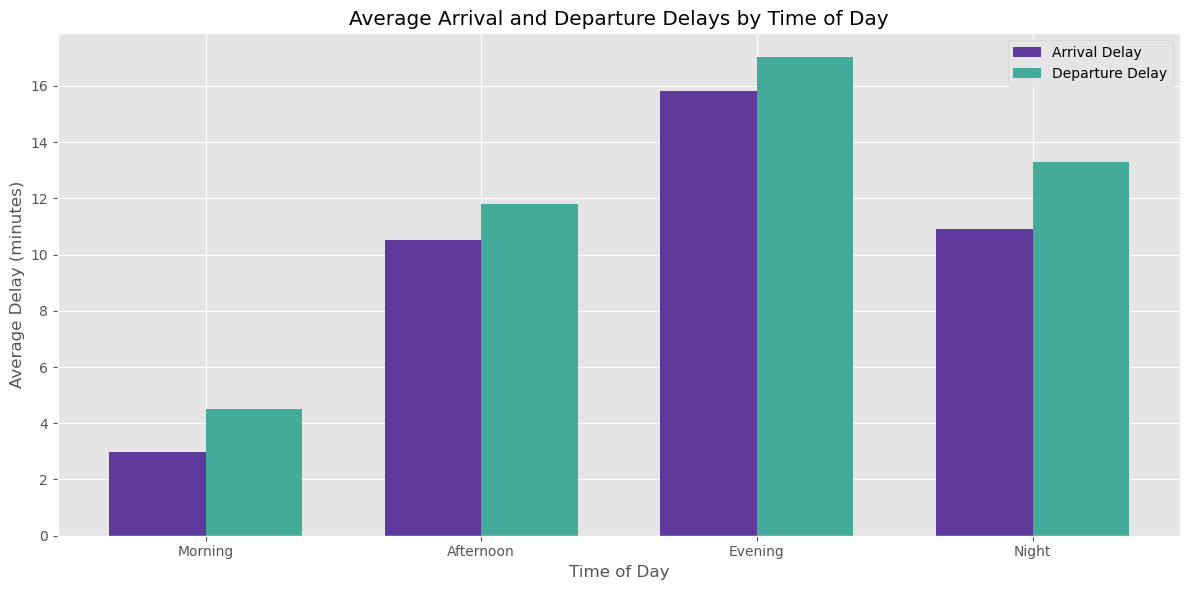

In [ ]:
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(time_order))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df1['avgarrivaldelay'], width, label='Arrival Delay', color='#5D3A9B')
plt.bar(x + width/2, df1['avgdeparturedelay'], width, label='Departure Delay', color='#44AA99')

# Add labels, title and legend
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Time of Day')
plt.xticks(x, time_order)
plt.legend()

plt.tight_layout()
plt.show()

The plot above reveals a clear and consistent pattern between arrival and departure delays across different times of the day. In general, **departure delays tend to be slightly more severe than arrival delays**, which is a common trend in aviation. This could be due to a range of factors such as late-arriving aircraft, longer ground operations, or congestion during take-off scheduling.

One of the most notable observations is that delays in departures and arrivals are generally **minimal in the morning hours**. This is likely because the day's operations are just beginning, and flights are more likely to start on schedule without the compounding effects of earlier disruptions. As the day progresses, however, **delays start to accumulate and peak during the late afternoon to evening hours**. This buildup can be attributed to the cascading impact of earlier flight disruptions, increased air traffic, and limited buffer times between flights.

This trend highlights the importance of early-day punctuality in maintaining operational flow, as morning efficiency can significantly influence the schedule stability throughout the day. For passengers and airlines alike, **this underscores the benefit of morning flights for more reliable on-time performance**.

### Which days of the week show better on-time performance?

After understanding the intra-day patterns of flight times, we can look at daily pattern of the flight to identify the best day to fly.

In [163]:
query2 = '''
SELECT
  DayOfWeek,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM data
WHERE Cancelled = 0
GROUP BY DayOfWeek
ORDER BY DayOfWeek DESC
'''

df2 = pull_data(query2)
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
0,7,8.139275,10.218353
1,6,5.169126,8.282844
2,5,12.320714,13.087679
3,4,11.575170,11.809365
4,3,7.977179,8.905728
5,2,6.195163,7.703996
6,1,8.842539,10.343310


In [164]:
# Map and sort the days of the week

df2 = df2.sort_values('dayofweek')
df2['dayofweek'] = df2['dayofweek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
6,Monday,8.842539,10.343310
5,Tuesday,6.195163,7.703996
4,Wednesday,7.977179,8.905728
3,Thursday,11.575170,11.809365
2,Friday,12.320714,13.087679
1,Saturday,5.169126,8.282844
0,Sunday,8.139275,10.218353


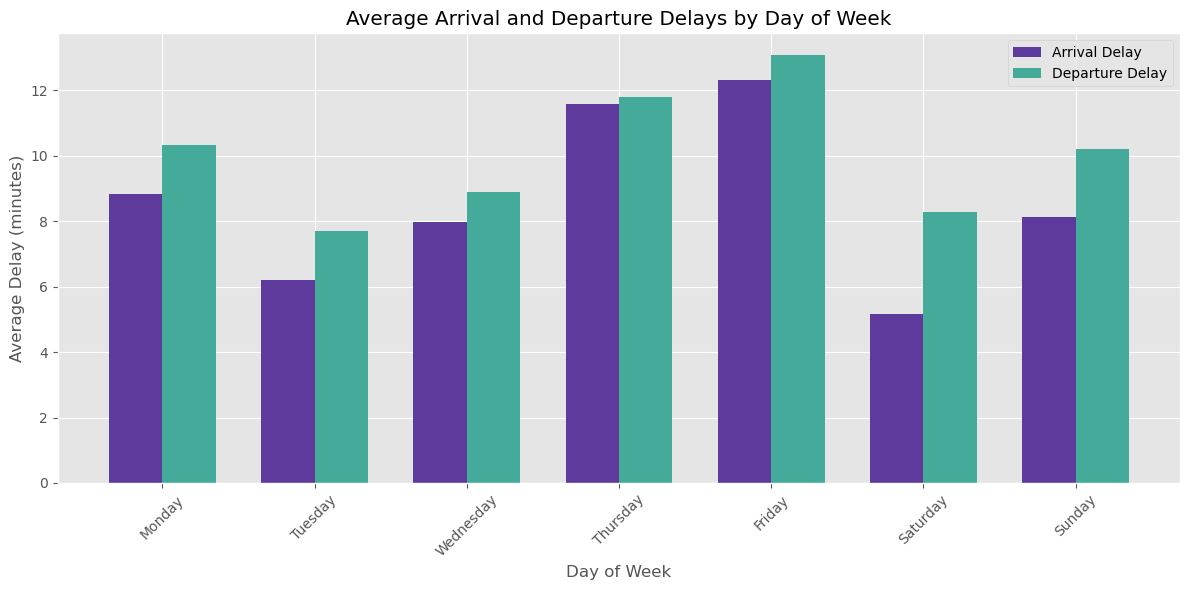

In [ ]:
# Plotting the average arrival and departure delays by time of day
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(df2['dayofweek']))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df2['avgarrivaldelay'], width, label='Arrival Delay', color='#5D3A9B')
plt.bar(x + width/2, df2['avgdeparturedelay'], width, label='Departure Delay', color='#44AA99')

# Add labels, title and legend
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Day of Week')
plt.xticks(x, df2['dayofweek'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

The analysis of delays by day of the week reveals several notable patterns. **Thursday and Friday** stand out with the **highest average delays**, hovering around **12 minutes** for both arrivals and departures. This spike toward the end of the workweek may reflect increased passenger volume due to business and leisure travel, leading to higher congestion at airports and busier airspace, which can amplify delays across the board.

**Saturday**, on the other hand, presents an **interesting contrast**. It records the **lowest average arrival delays**, suggesting smoother inbound operations possibly due to reduced traffic or more buffer in scheduling. However, it still experiences **moderate departure delays**, which could result from factors such as late aircraft arrivals from earlier flights, fewer operational resources, or scheduling constraints unique to weekend operations.

**Tuesday** emerges as a **balanced day** with relatively **low average delays for both arrivals and departures**. This may be attributed to lower midweek travel demand, allowing for more efficient airport and airline operations with fewer disruptions.

In summary, while Thursday and Friday tend to be more delay-prone due to peak travel activity, Saturday’s arrival-departure mismatch and Tuesday’s consistency offer insights for travelers and airline planners aiming to minimize delay exposure.

### During which months or seasons are flights most likely to be on time?

We have identified that Tuesdays provide a good trade-off of arrival and departure delays. We can scale it up again to then identify which months/seasons has the best on-time performance.

Since this dataset is from the US, we have to follow the distribution of seasons according to the month as;

+ Winter : Dec, Jan, Feb
+ Spring : March, Apr, May
+ Summer : June, Jul, Aug
+ Autumn : Sept, Oct, Nov

We then can again, look the performance of both arrival and departure delays.

In [16]:
query3 = '''
SELECT
  Month,
  CASE
    WHEN month in (12,1,2) THEN "Winter" 
    WHEN month in (3,4,5) THEN "Spring"
    WHEN month in (6,7,8) THEN "Summer"
    WHEN month in (9,10,11) THEN "Autumn"
  END AS Season,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM data
WHERE Cancelled = 0
GROUP BY Month
ORDER BY Month ASC
'''

df3 = pull_data(query3)
df3

,month,season,avgarrivaldelay,avgdeparturedelay
0,1,Winter,5.628671,8.078217
1,2,Winter,7.359394,9.142588
2,3,Spring,7.926261,9.755771
3,4,Spring,6.423710,8.194028
4,5,Spring,6.887169,8.540832
5,6,Summer,12.045558,12.933677
6,7,Summer,11.311534,12.703436
7,8,Summer,8.687387,9.936825
8,9,Autumn,8.394923,8.760106
9,10,Autumn,10.687462,10.645492


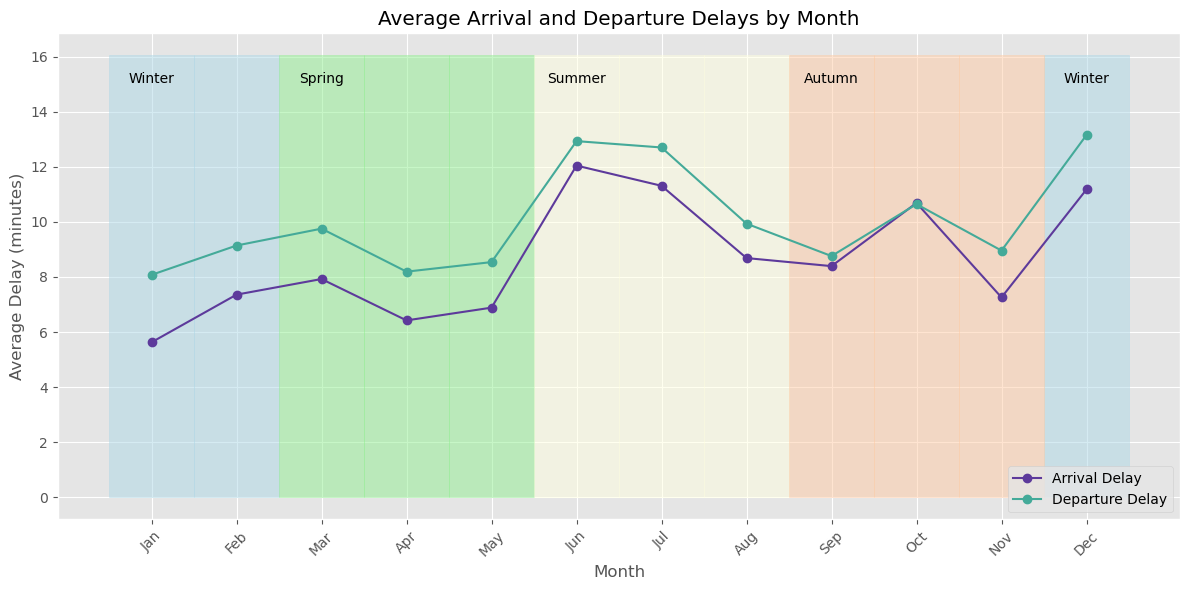

In [17]:
# Plot line chart for average arrival and departure delays by month
plt.figure(figsize=(12, 6))

plt.plot(df3['month'], df3['avgarrivaldelay'], marker='o', label='Arrival Delay', color='#5D3A9B')
plt.plot(df3['month'], df3['avgdeparturedelay'], marker='o', label='Departure Delay', color='#44AA99')

# Season colors
season_colors = {
    'Winter': '#ADD8E6',  # Light blue
    'Spring': '#90EE90',  # Light green
    'Summer': '#FFFFE0',  # Light yellow
    'Autumn': '#FFCBA4'     # Light orange/peach
}

# Create a list to store legend elements
legend_elements = []

# Get the maximum y-value for the fill (slightly above the max delay)
max_y = df3['avgarrivaldelay'].max() + 4

# Add seasonal shading with improved approach to avoid gaps
for season in df3['season'].unique():
    # Extract month values where season matches
    season_data = df3[df3['season'] == season]
    
    # Create extended x values for each month to create blocks
    for _, row in season_data.iterrows():
        month = row['month']
        # Create rectangular blocks by extending 0.5 in both directions
        x_rect = [month - 0.5, month + 0.5, month + 0.5, month - 0.5]
        y_rect = [0, 0, max_y, max_y]
        
        plt.fill(x_rect, y_rect, color=season_colors[season], alpha=0.5, zorder=1)
    
    # Add to legend elements (only once per season)
    from matplotlib.patches import Patch
    legend_elements.append(Patch(facecolor=season_colors[season], alpha=0.5, label=season))

# Add lines to legend elements
line_elements = plt.gca().get_legend_handles_labels()[0]
legend_elements = line_elements + legend_elements

# Add text labels for seasons for better visibility
plt.text(1, max_y-1, 'Winter', fontsize=10, color='black', ha='center')
plt.text(3, max_y-1, 'Spring', fontsize=10, color='black', ha='center')
plt.text(6, max_y-1, 'Summer', fontsize=10, color='black', ha='center')
plt.text(9, max_y-1, 'Autumn', fontsize=10, color='black', ha='center')
plt.text(12, max_y-1, 'Winter', fontsize=10, color='black', ha='center')

plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Month')
plt.xticks(df3['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


**Flight delays tend to peak in June and December**, which coincide with the start of major holiday seasons. These busy periods see more passengers, leading to crowded airports and increased delays. In contrast, **spring months have the lowest delays** due to lighter travel and better weather, while autumn shows moderate delays with a dip in September and a small rise in October.

Looking at daily and weekly patterns, two clear conclusions emerge:

* **Worst time to fly:** Friday evenings during early summer and winter holidays, when many travelers start their trips, causing crowded airports and more delays.
* **Best time to fly:** Tuesday mornings in mid-spring, when passenger traffic is low and operations run smoothly, resulting in fewer delays.

Understanding these patterns can help travelers choose better flight times and avoid unnecessary delays.


## 2. Delay Factors

### Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset and quantify the impact of each factor (in minutes of delay and percentage of total delays).

While it is ideal to avoid flight delays by selecting optimal travel times, real-life constraints such as work commitments, holiday schedules, or limited flight availability often make this difficult. Therefore, it becomes essential to understand the underlying causes of flight delays, as provided in this dataset. The main contributing factors include:

1. Late Aircraft Delay
1. Weather Delay
1. Carrier Delay
1. NAS (National Airspace System) Delay
1. Security Delay

By analyzing which of these factors contribute most significantly to overall delay times, travelers can make more informed decisions. For example, delays due to weather or airline-specific operational inefficiencies may be anticipated and planned for. This enables passengers to mitigate the impact of delays by choosing more reliable carriers, adjusting schedules where possible, or allowing additional buffer time when traveling during high-risk periods.

In [18]:
query4 = '''
SELECT
  DelayType,
  AvgDelayMinutes,
  IncidentCount
FROM (
  SELECT 'CarrierDelay' AS DelayType,
         AVG(CarrierDelay) AS AvgDelayMinutes,
         SUM(CASE WHEN CarrierDelay > 0 THEN 1 ELSE 0 END) AS IncidentCount
  FROM data
  WHERE CarrierDelay > 0

  UNION ALL

  SELECT 'WeatherDelay',
         AVG(WeatherDelay),
         SUM(CASE WHEN WeatherDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE WeatherDelay > 0

  UNION ALL

  SELECT 'NASDelay',
         AVG(NASDelay),
         SUM(CASE WHEN NASDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE NASDelay > 0

  UNION ALL

  SELECT 'SecurityDelay',
         AVG(SecurityDelay),
         SUM(CASE WHEN SecurityDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE SecurityDelay > 0

  UNION ALL

  SELECT 'LateAircraftDelay',
         AVG(LateAircraftDelay),
         SUM(CASE WHEN LateAircraftDelay > 0 THEN 1 ELSE 0 END)
  FROM data
  WHERE LateAircraftDelay > 0
) AS DelaySummary
ORDER BY AvgDelayMinutes DESC
LIMIT 5
'''
df4 = pull_data(query4)
df4

,delaytype,avgdelayminutes,incidentcount
0,LateAircraftDelay,44.092380,731324
1,WeatherDelay,42.673773,113743
2,CarrierDelay,33.765334,718349
3,NASDelay,27.191464,941866
4,SecurityDelay,20.741216,10673


In [19]:
df4['incident_percent'] = df4['incidentcount'] / df4['incidentcount'].sum() * 100
df4['incident_percent'] = df4['incident_percent'].round(2)

df4

,delaytype,avgdelayminutes,incidentcount,incident_percent
0,LateAircraftDelay,44.092380,731324,29.07
1,WeatherDelay,42.673773,113743,4.52
2,CarrierDelay,33.765334,718349,28.55
3,NASDelay,27.191464,941866,37.44
4,SecurityDelay,20.741216,10673,0.42


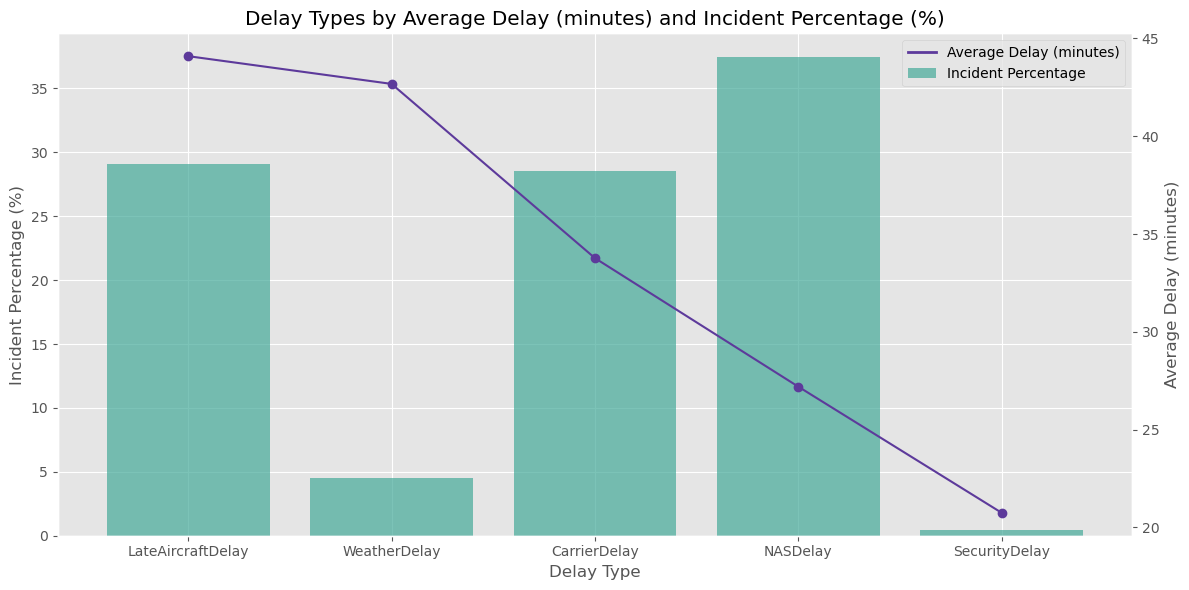

In [235]:
# Plot delaytype vs delaymins and incident percentage on second axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df4['delaytype'], df4['incident_percent'], color='#44AA99', alpha=0.7, label='Incident Percentage')
ax1.set_xlabel('Delay Type')
ax1.set_ylabel('Incident Percentage (%)')
ax1.set_title('Delay Types by Average Delay (minutes) and Incident Percentage (%)')

# Create a second y-axis for the incident percentage
ax2 = ax1.twinx()
ax2.plot(df4['delaytype'], df4['avgdelayminutes'], color='#5D3A9B', marker='o', label='Average Delay (minutes)')
ax2.set_ylabel('Average Delay (minutes)')

# Create a custom legend for both
legend_elements = [
    plt.Line2D([0], [0], color='#5D3A9B', lw=2, label='Average Delay (minutes)'),
    Patch(facecolor='#44AA99', alpha=0.7, label='Incident Percentage')
]

plt.legend(handles=legend_elements)
plt.grid()
plt.tight_layout()
plt.show()

Analyzing delay incidents by their cause reveals an interesting contrast. NAS (National Airspace System) delays account for roughly 35% of all delay incidents, making them the most common type. However, their average delay duration is relatively short, about 28 minutes per incident. This suggests that **while NAS delays happen frequently, they tend to be shorter and less disruptive on average**.

On the other hand, weather-related delays are much less common, representing only around 5% of total incidents. Despite their rarity, these delays have the greatest impact on flight schedules, with an average delay time of approximately 43 minutes. **Weather conditions often cause significant disruptions** due to safety concerns and limited operational capacity, leading to longer delays when they occur.

In summary, NAS delays contribute more frequently to flight delays but usually for shorter durations, whereas weather delays are infrequent but tend to cause longer and more severe disruptions.

## 3. Cancellation Analysis

### Identify the primary reasons for flight cancellations as categorized in the dataset.

Another factor to look at to identify poor performing flights is to look at cancellations. We have successfully identified delay patterns and causes, we can look into cancellations as well. From the provided dataset description, the cancellation code is similar to the delays with the exception of Late Aircraft.

1. Weather Delay
1. Carrier Delay
1. NAS (National Airspace System) Delay
1. Security Delay

In [21]:
query5 = '''
SELECT
	CASE
		WHEN CancellationCode = "A" THEN "Carrier"
		WHEN CancellationCode = "B" THEN "Weather"
		WHEN CancellationCode = "C" THEN "NAS"
		WHEN CancellationCode = "D" THEN "Security"
	END as cancellation_code,
	SUM(Cancelled) as count_cancellation
FROM data
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY count_cancellation DESC
'''

df5 = pull_data(query5)
df5

,cancellation_code,count_cancellation
0,Carrier,55655
1,Weather,37913
2,NAS,28209
3,Security,157


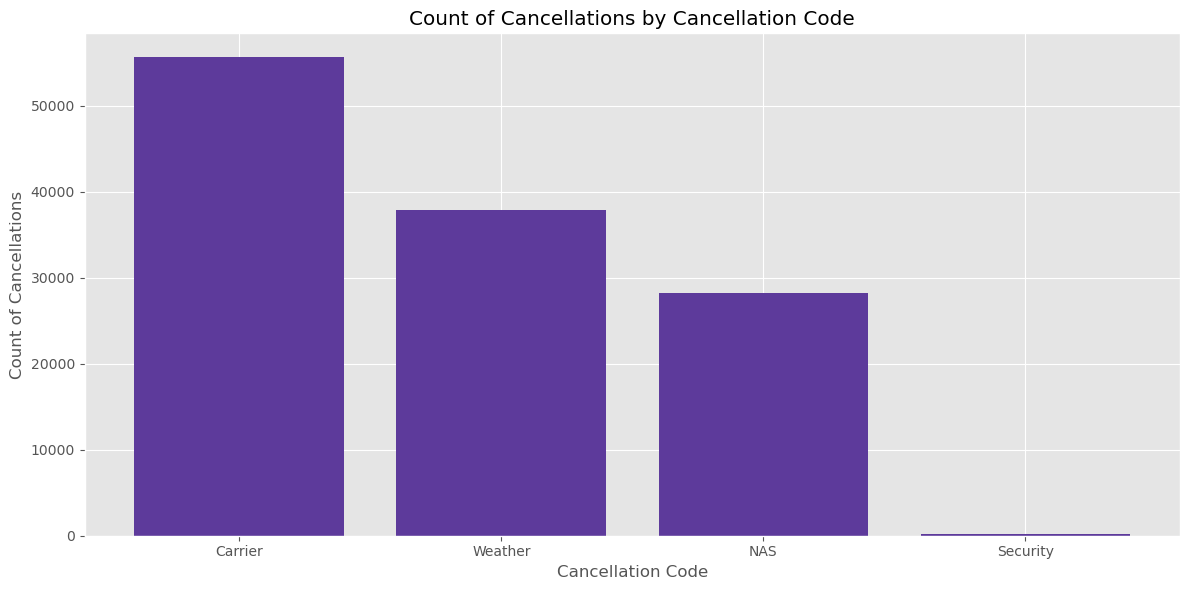

In [22]:
# Plot the count of cancellations by cancellation code
plt.figure(figsize=(12, 6))
plt.bar(df5['cancellation_code'], df5['count_cancellation'], color='#5D3A9B')
plt.xlabel('Cancellation Code')
plt.ylabel('Count of Cancellations')
plt.title('Count of Cancellations by Cancellation Code')
plt.tight_layout()
plt.show()

**Carrier-related issues are the primary reason for flight cancellations**, making up the largest share in the dataset. Weather conditions come next, followed by cancellations due to National Airspace System (NAS) factors and security concerns. However, the dataset does not provide specific details on the exact causes behind these cancellations. For example, whether carrier cancellations are due to staffing, mechanical problems, or scheduling conflicts. Because of this lack of detailed information, further investigation is necessary to uncover the root causes of these cancellations. This deeper analysis will be addressed later to provide better insights into the factors driving flight cancellations.

### Determine if cancellations correlate with specific airlines, airports, or time periods.

#### Airline

Firstly, we can identify if there are specific airlines which is causing this cancellations as the primary cause of cancellations is the carrier.

In [23]:
query7 = '''
SELECT * 
FROM (
    SELECT 
        d.UniqueCarrier AS CarrierCode,
        c.Description AS Description,
        SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
        COUNT(*) AS total_flights,
        ROUND(100.0 * SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
    FROM 
        data d
    LEFT JOIN 
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY 
        d.UniqueCarrier, c.Description
) sub
ORDER BY 
    cancellation_rate_pct DESC
'''

df7 = pull_data(query7)
df7

,carriercode,description,cancellation_count,total_flights,cancellation_rate_pct
0,MQ,American Eagle Airlines Inc.,19990,550088,3.63
1,YV,Mesa Airlines Inc.,9544,304764,3.13
2,EV,Atlantic Southeast Airlines,6783,273143,2.48
3,OH,Comair Inc.,6875,278099,2.47
4,OO,Skywest Airlines Inc.,12844,548109,2.34
5,XE,Expressjet Airlines Inc.,9716,441470,2.20
6,AQ,Aloha Airlines Inc.,745,35387,2.11
7,UA,United Air Lines Inc.,10238,500008,2.05
8,AA,American Airlines Inc.,10127,643597,1.57
9,DL,Delta Air Lines Inc.,7695,506086,1.52


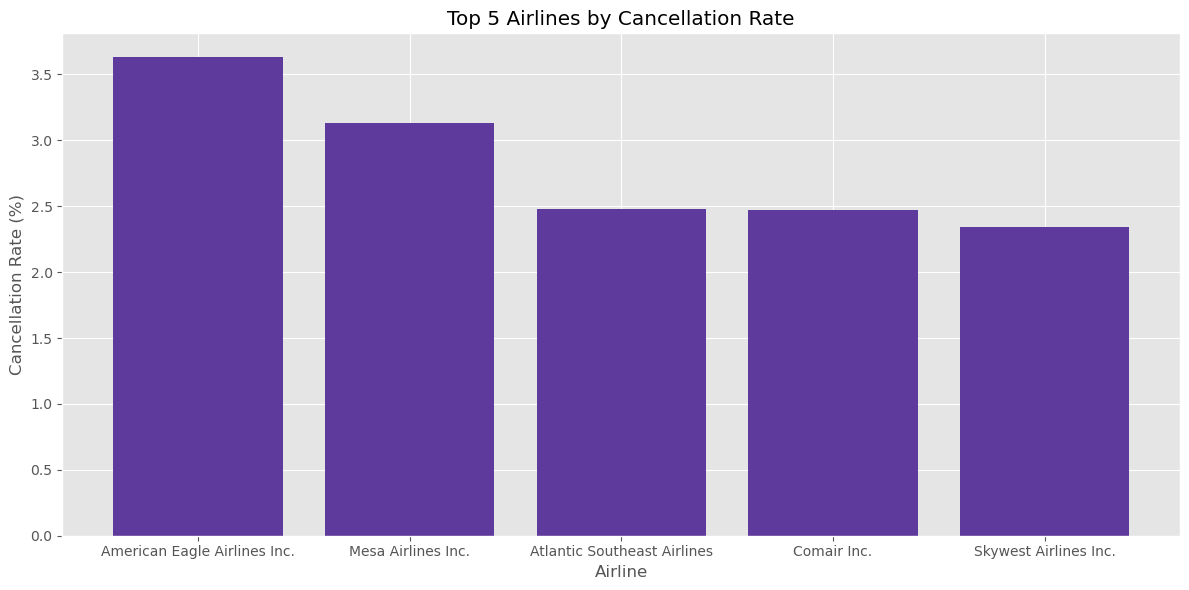

In [24]:
# Plot top 5 carriers by cancellation rate
top5_airline_cancellation = df7.head(5)
plt.figure(figsize=(12, 6))
plt.bar(top5_airline_cancellation['description'], top5_airline_cancellation['cancellation_rate_pct'], color='#5D3A9B')
plt.xlabel('Airline')
plt.ylabel('Cancellation Rate (%)')
plt.title('Top 5 Airlines by Cancellation Rate')
plt.tight_layout()
plt.show()

We can see that American Eagle Airlines Inc. shows the highest cancellation rate of 3.6%, followed by Mesa Airlines Inc., Atlantic Southeast Airlines, Comar Inc., and Skywest Airlines Inc.

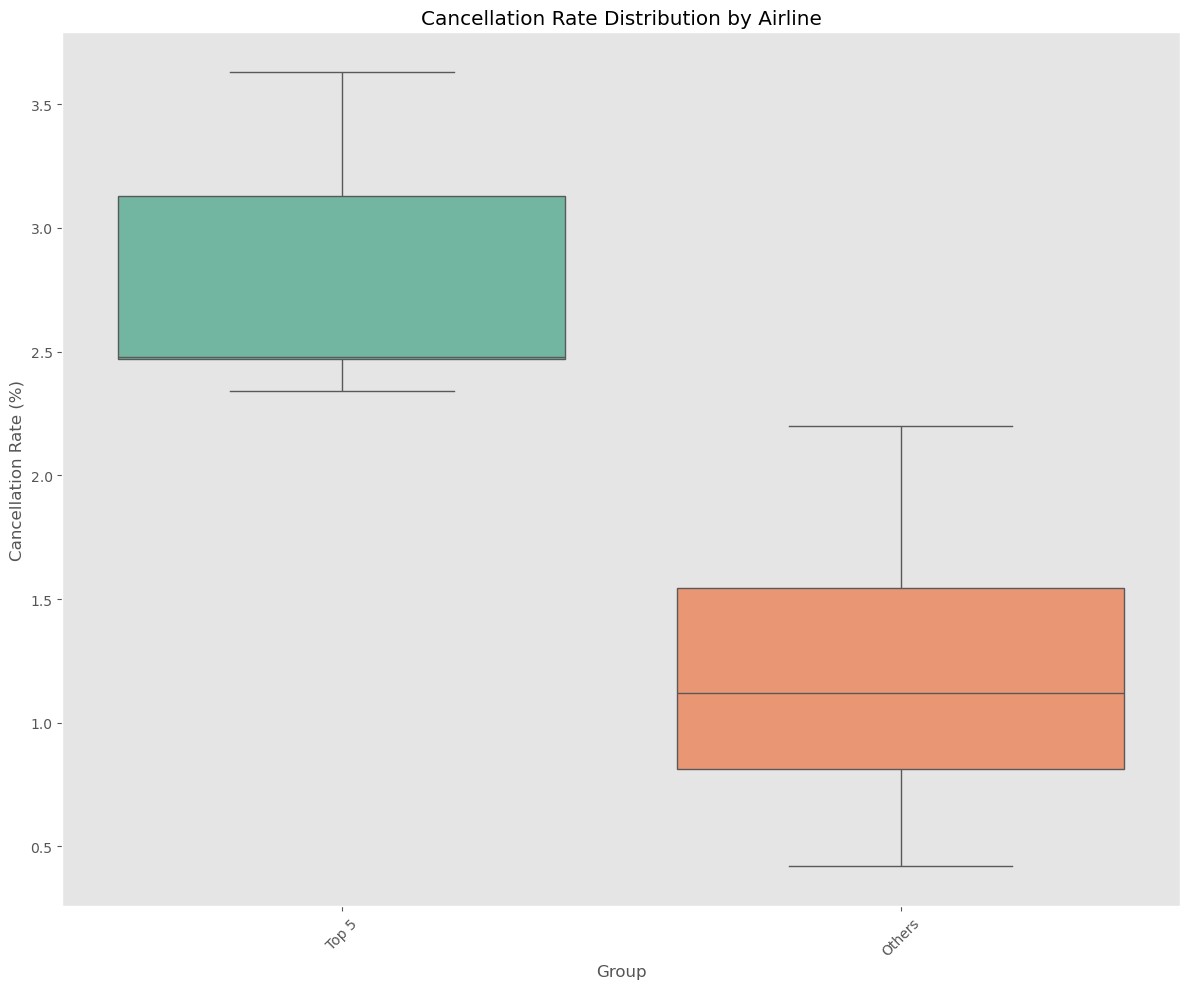

In [198]:
# Group the top 5 airlines by cancellation rate
top5 = df7.head(5)
top5_airline = top5['description'].tolist()

df7['Group'] = df7['description'].apply(lambda x: 'Top 5' if x in top5_airline else 'Others')

# Create a violinplot for the top 5 airlines compare to the rest
plt.figure(figsize=(12, 10))
sns.boxplot(x='Group', y='cancellation_rate_pct', data=df7, palette='Set2')
plt.title('Cancellation Rate Distribution by Airline')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We can compare the mean cancellation rate between the top 5 against the rest. Given a $\alpha$ of 0.05, and hypothesis of;

$$
H_0 \text{: There is no significant difference in the mean cancellation rate between the Top 5 airlines and other airlines.}
\newline
H_1 \text{: There is a significant difference in the mean cancellation rate between the Top 5 airlines and other airlines.}
$$



In [199]:
# Compare means of the top 5 airlines with the rest with t-test
from scipy.stats import ttest_ind

top5_data = df7[df7['Group'] == 'Top 5']['cancellation_rate_pct']
others_data = df7[df7['Group'] == 'Others']['cancellation_rate_pct']

t_stat, p_value = ttest_ind(top5_data, others_data, equal_var=False)

print(f"T-statistic: {t_stat}, \nP-value: {p_value}")

T-statistic: 5.465182999670966, 
P-value: 0.0008254433240378721


P-value < $\alpha$, $H_0$ is rejected. There is statistically significant evidence to suggest that the average cancellation rate differs between the Top 5 airlines and the other airlines.

#### Airport

Another factor to look into is the airports. Due to differences in location, weather differences may be aparent in each airports. Thus, it is crucial to see if airport location plays a role in cancellation rates.

In [37]:
query6 = '''
WITH airport_stats AS (
    SELECT COALESCE(o.Origin, d.Dest) AS AirportCode, 
           o.cancellation_count AS Origin_Cancellation_count, 
           o.total_flights AS Origin_Total_Flights, 
           CASE WHEN o.total_flights > 0 THEN (o.cancellation_count * 100.0 / o.total_flights) ELSE 0 END AS Origin_Cancellation_Rate, 
           d.cancellation_count AS Dest_Cancellation_count, 
           d.total_flights AS Dest_Total_Flights, 
           CASE WHEN d.total_flights > 0 THEN (d.cancellation_count * 100.0 / d.total_flights) ELSE 0 END AS Dest_Cancellation_Rate
    FROM (
        SELECT Origin, 
               SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
               COUNT(*) AS total_flights 
        FROM data 
        GROUP BY Origin
    ) o 
    FULL OUTER JOIN (
        SELECT Dest, 
               SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
               COUNT(*) AS total_flights 
        FROM data 
        GROUP BY Dest
    ) d ON o.Origin = d.Dest
)

SELECT 
    a.AirportCode,
    ap.airport AS AirportName,
    ap.city AS City,
    ap.state AS State,
    ap.country AS Country,
    ap.lat AS Latitude,
    ap.long AS Longitude,
    a.Origin_Cancellation_count,
    a.Origin_Total_Flights,
    a.Origin_Cancellation_Rate,
    a.Dest_Cancellation_count,
    a.Dest_Total_Flights,
    a.Dest_Cancellation_Rate
FROM 
    airport_stats a
LEFT JOIN 
    airports ap ON a.AirportCode = ap.iata
ORDER BY 
    a.Origin_Cancellation_Rate DESC, 
    a.Dest_Cancellation_Rate DESC
'''

df6 = pull_data(query6)
df6.head()

,airportcode,airportname,city,state,country,latitude,longitude,origin_cancellation_count,origin_total_flights,origin_cancellation_rate,dest_cancellation_count,dest_total_flights,dest_cancellation_rate
0,TEX,Telluride Regional,Telluride,CO,USA,37.953759,-107.908480,33.0,273.0,12.087912,15.0,273.0,5.494505
1,HKY,Hickory Municipal,Hickory,NC,USA,35.741146,-81.389549,5.0,42.0,11.904762,5.0,41.0,12.195122
2,ACK,Nantucket Memorial,Nantucket,MA,USA,41.253052,-70.060181,26.0,235.0,11.063830,27.0,235.0,11.489362
3,ADK,Adak,Adak,AK,USA,51.877964,-176.646031,11.0,104.0,10.576923,11.0,104.0,10.576923
4,ASE,Aspen-Pitkin Co/Sardy,Aspen,CO,USA,39.223160,-106.868845,294.0,3733.0,7.875703,270.0,3716.0,7.265877


##### Origin Cancellation Rate

Due to the nature of the dataset, we can again separate the analysis into origin cancellation and destination cancellation. Origin cancellation refers to the flights that are cancelled before departure, and passengers are still at the departure gate or check-in. Often due to weather at the origin location, aircraft unavailability, crew scheduling, or airport closures.

In [205]:
# Sort and select top 5 airports by origin cancellation rate
top5 = df6.sort_values(by='origin_cancellation_rate', ascending=False).head(5)
top5_codes = top5['airportname'].tolist()

print("Top 5 Airports by Origin Cancellation Rate:")
for index, row in top5.iterrows():
    print(f"{row['airportname']} ({row['airportcode']}): {row['origin_cancellation_rate']:.2f}%")


Top 5 Airports by Origin Cancellation Rate:
Telluride Regional (TEX): 12.09%
Hickory Municipal (HKY): 11.90%
Nantucket Memorial (ACK): 11.06%
Adak (ADK): 10.58%
Aspen-Pitkin Co/Sardy  (ASE): 7.88%


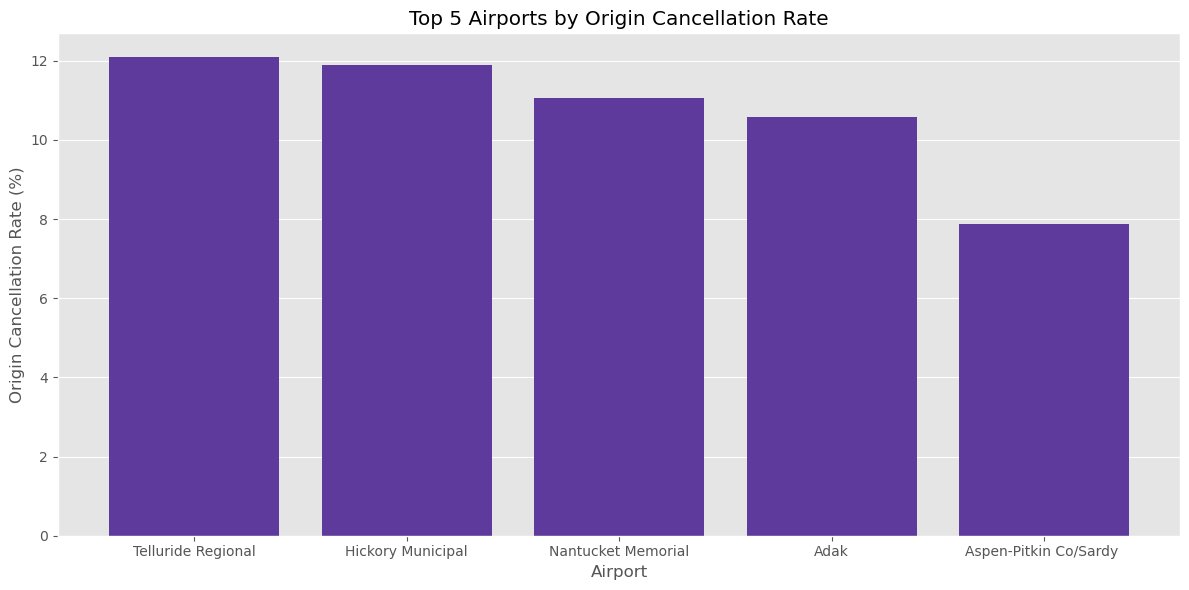

In [209]:
# Plot the top 5 airports by origin cancellation rate
plt.figure(figsize=(12, 6))
plt.bar(top5['airportname'], top5['origin_cancellation_rate'], color='#5D3A9B')
plt.xlabel('Airport')
plt.ylabel('Origin Cancellation Rate (%)')
plt.title('Top 5 Airports by Origin Cancellation Rate')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


From the plot above we can see the top 5 origin airports with highest cancellation rates.

In [196]:
# Add a new column indicating if the airport is in top 5
df6['Group'] = df6['airportname'].apply(lambda x: 'Top 5' if x in top5_codes else 'Others')

# Drop missing cancellation rates
df_clean = df6.dropna(subset=['origin_cancellation_rate', 'dest_cancellation_rate'])


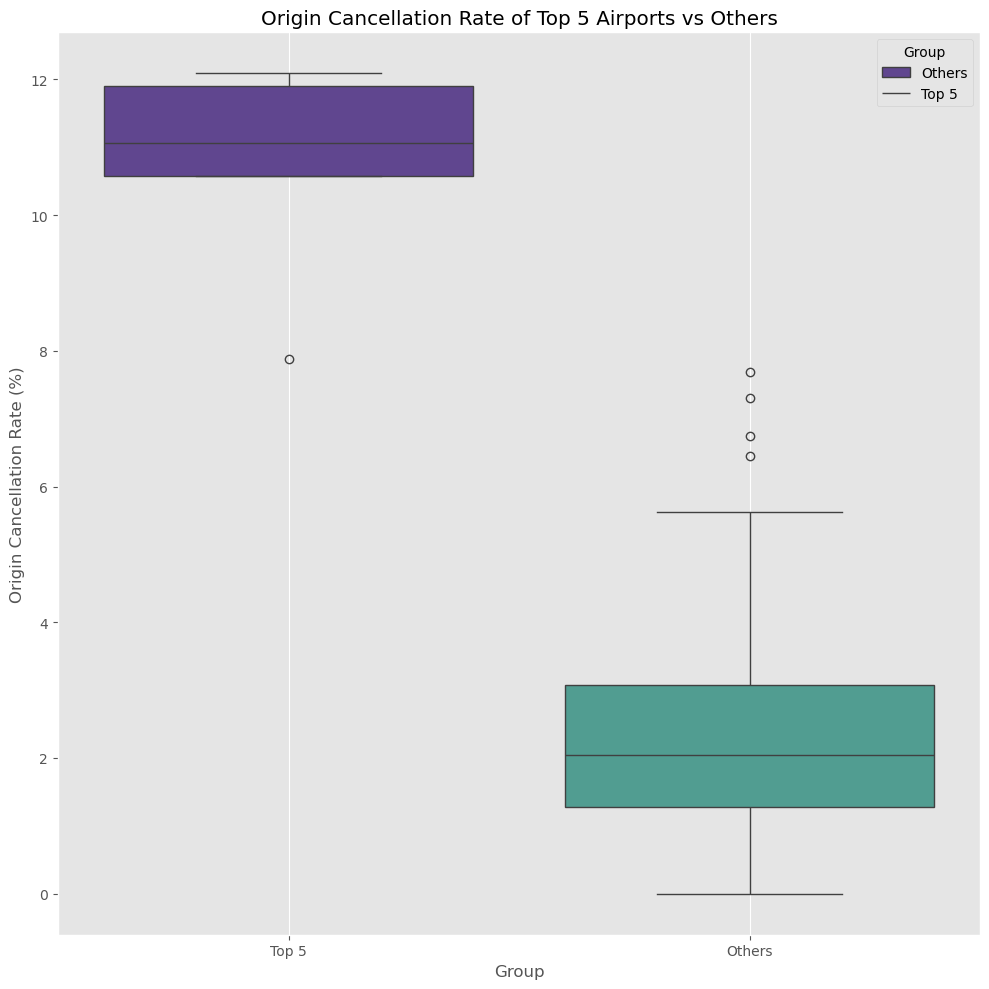

In [201]:
# Plot the cancellation count of top 5 airports vs others
plt.figure(figsize=(10, 10))
sns.boxplot(x='Group', y='origin_cancellation_rate', data=df_clean, palette=['#5D3A9B', '#44AA99'])
plt.title('Origin Cancellation Rate of Top 5 Airports vs Others')
plt.xlabel('Group')
plt.ylabel('Origin Cancellation Rate (%)')
plt.xticks(rotation=0)
plt.legend(title='Group', loc='upper right', labels=['Others', 'Top 5'])
plt.grid()
plt.tight_layout()
plt.show()

Similarly, we can compare the mean cancellation count between the top 5 against the rest. Given a $\alpha$ of 0.05, and hypothesis of;

$$
H_0 \text{: There is no significant difference in the mean origin cancellation rate between the Top 5 airlines and other airlines.}
\newline
H_1 \text{: There is a significant difference in the mean origin cancellation rate between the Top 5 airlines and other airlines.}
$$



In [210]:
from scipy.stats import ttest_ind

top5_rates = df_clean[df_clean['Group'] == 'Top 5']['origin_cancellation_rate']
others_rates = df_clean[df_clean['Group'] == 'Others']['origin_cancellation_rate']

t_stat, p_val = ttest_ind(top5_rates, others_rates, equal_var=False)

print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_val:.4f}")


Welch's t-test: t = 11.0341, p = 0.0003


P-value < $\alpha$, $H_0$ is rejected. There is statistically significant evidence to suggest that the average origin cancellation rate differs between the Top 5 airlines and the other airlines.

##### Destination Cancellation Rate

Next, we look at destination cancellation rates. Destionation cancellation refers to cases in which flight cannot land at the intended destination, possibly even after take off. As a result, flights may return to origin or diverted to other airports. Often times, due to harsh weather conditions, emergencies, or security alerts.

In [211]:
# Sort and select top 5 airports by origin cancellation rate
top5 = df6.sort_values(by='dest_cancellation_rate', ascending=False).head(5)
top5_codes = top5['airportname'].tolist()

print("Top 5 Airports by Destination Cancellation Rate:")
for index, row in top5.iterrows():
    print(f"{row['airportname']} ({row['airportcode']}): {row['origin_cancellation_rate']:.2f}%")


Top 5 Airports by Destination Cancellation Rate:
Hickory Municipal (HKY): 11.90%
Nantucket Memorial (ACK): 11.06%
Adak (ADK): 10.58%
Kodiak  (ADQ): 7.31%
Aspen-Pitkin Co/Sardy  (ASE): 7.88%


In [212]:
# Add a new column indicating if the airport is in top 5
df6['Group'] = df6['airportname'].apply(lambda x: 'Top 5' if x in top5_codes else 'Others')

# Drop missing cancellation rates
df_clean = df6.dropna(subset=['origin_cancellation_rate', 'dest_cancellation_rate'])


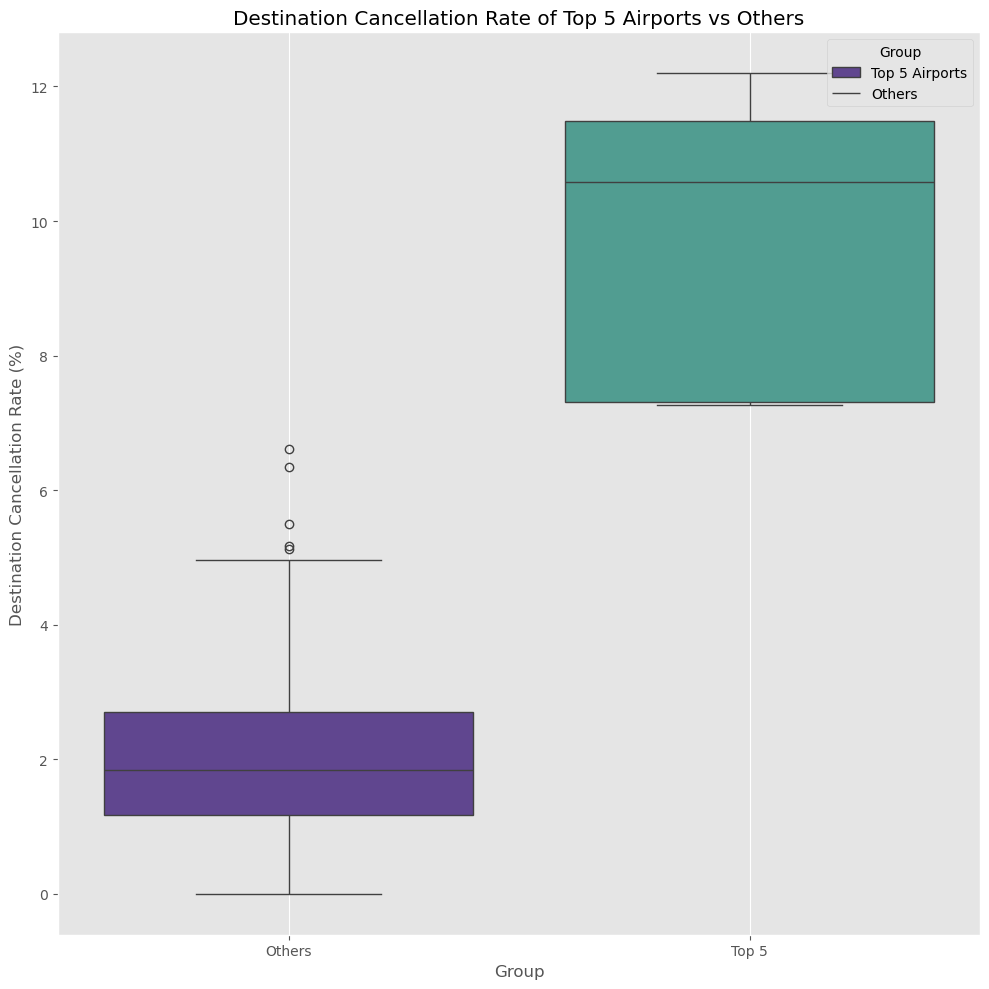

In [214]:
# Plot the cancellation rate of top 5 airports vs others
plt.figure(figsize=(10, 10))
sns.boxplot(x='Group', y='dest_cancellation_rate', data=df_clean, palette=['#5D3A9B', '#44AA99'])
plt.title('Destination Cancellation Rate of Top 5 Airports vs Others')
plt.xlabel('Group')
plt.ylabel('Destination Cancellation Rate (%)')
plt.legend(title='Group', loc='upper right', labels=['Top 5 Airports', 'Others'])
plt.grid()
plt.tight_layout()
plt.show()

Just as above we can compare the mean destination cancellation rate between the top 5 against the rest. Given a $\alpha$ of 0.05, and hypothesis of;

$$
H_0 \text{: There is no significant difference in the mean destination cancellation rate between the Top 5 airlines and other airlines.}
\newline
H_1 \text{: There is a significant difference in the mean destination cancellation rate between the Top 5 airlines and other airlines.}
$$



In [215]:
from scipy.stats import ttest_ind

top5_rates = df_clean[df_clean['Group'] == 'Top 5']['dest_cancellation_rate']
others_rates = df_clean[df_clean['Group'] == 'Others']['dest_cancellation_rate']

t_stat, p_val = ttest_ind(top5_rates, others_rates, equal_var=False)

print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_val:.4f}")


Welch's t-test: t = 7.3900, p = 0.0017


P-value < $\alpha$, $H_0$ is rejected. There is statistically significant evidence to suggest that the average origin cancellation rate differs between the Top 5 airlines and the other airlines.

##### Combined Plot

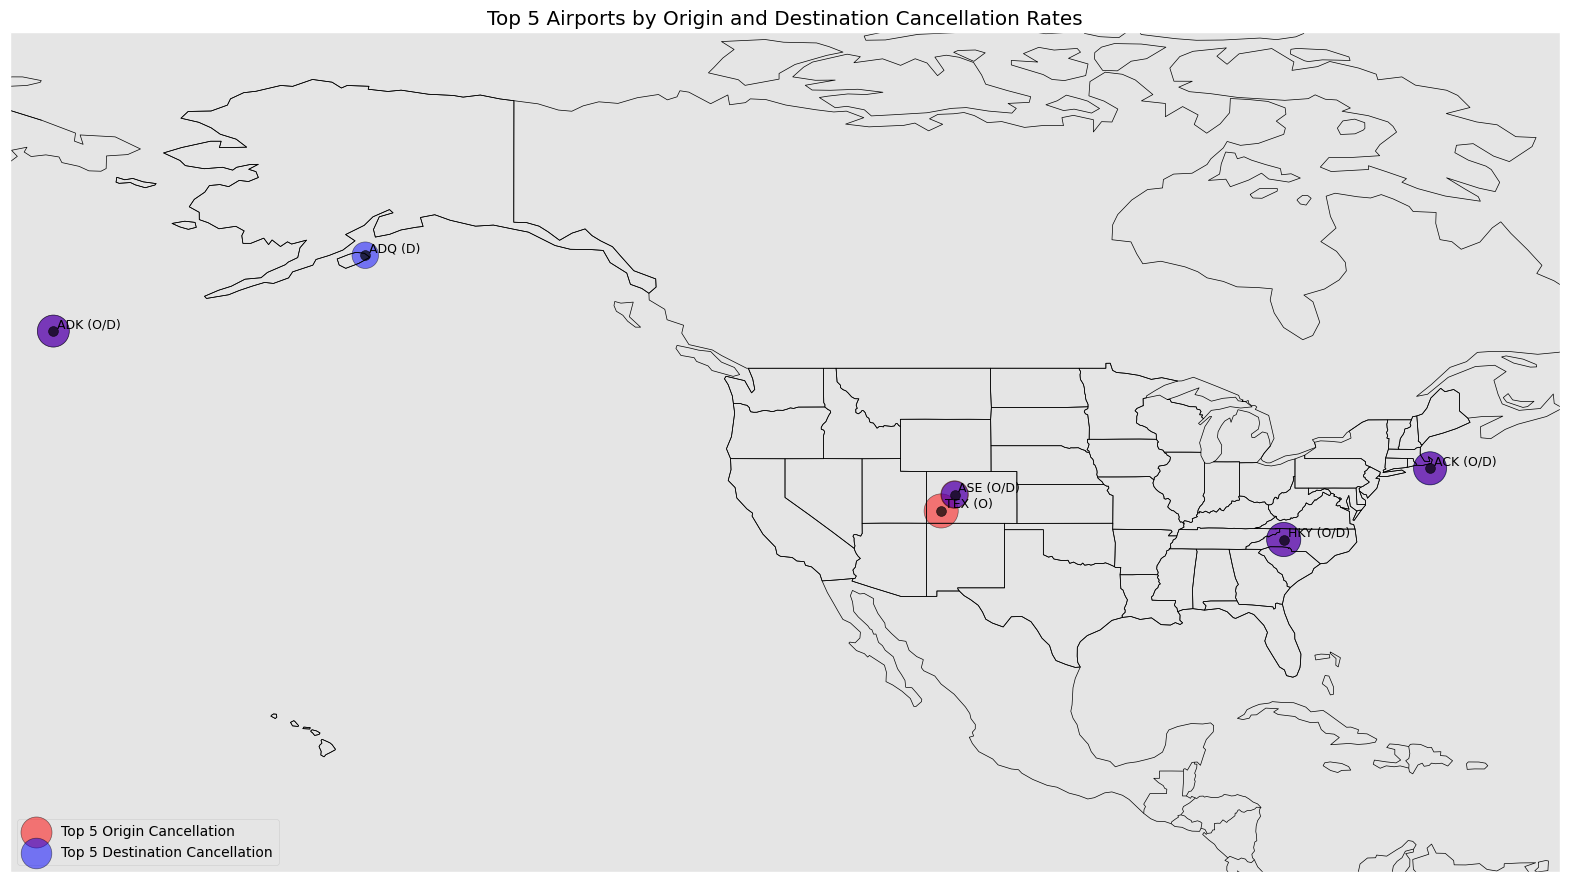

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select top 5 by origin and destination cancellation rate
top5_origin = df6.sort_values(by='origin_cancellation_rate', ascending=False).head(5)
top5_dest = df6.sort_values(by='dest_cancellation_rate', ascending=False).head(5)

# Set up the map
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_extent([-180, -60, 10, 75], crs=ccrs.PlateCarree())


# Plot top 5 origin cancellation airports
origin_scatter = ax.scatter(
    top5_origin['longitude'],
    top5_origin['latitude'],
    s=top5_origin['origin_cancellation_rate'] * 50,
    color='red',
    alpha=0.5,
    label='Top 5 Origin Cancellation',
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Plot top 5 destination cancellation airports
dest_scatter = ax.scatter(
    top5_dest['longitude'],
    top5_dest['latitude'],
    s=top5_dest['dest_cancellation_rate'] * 50,
    color='blue',
    alpha=0.5,
    label='Top 5 Destination Cancellation',
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Add airport names to the scatter points
# If origin and destination airports have the same name, use 1 label
# Combine top5 origin and destination airports
combined = pd.concat([top5_origin, top5_dest]).drop_duplicates(subset='airportcode')

# Add a column indicating label type: O, D, or both
def get_label_type(row):
    is_origin = row['airportcode'] in top5_origin['airportcode'].values
    is_dest = row['airportcode'] in top5_dest['airportcode'].values
    if is_origin and is_dest:
        return '(O/D)'
    elif is_origin:
        return '(O)'
    elif is_dest:
        return '(D)'

combined['label'] = combined.apply(get_label_type, axis=1)

# Plot all combined airports with appropriate colors and labels
for _, row in combined.iterrows():
    color = 'black'
    ax.scatter(row['longitude'], row['latitude'],
               s=50,
               color=color,
               alpha=0.7,
               edgecolor='k',
               transform=ccrs.PlateCarree())

    ax.text(row['longitude'] + 0.3, row['latitude'] + 0.3,
            f"{row['airportcode']} {row['label']}",
            fontsize=9,
            color=color,
            transform=ccrs.PlateCarree())

plt.title('Top 5 Airports by Origin and Destination Cancellation Rates')
plt.legend(loc='lower left')
plt.show()


**🔍 Key Differences in Origin vs Departure Cancellations:**

| Aspect                 | Origin Cancellation                            | Destination Cancellation                       |
| ---------------------- | ---------------------------------------------- | ---------------------------------------------- |
| **Flight Status**      | Cancelled before takeoff                       | May take off, then diverted or returned        |
| **Cause**              | Origin-side issues                             | Destination-side issues                        |
| **Passenger Location** | Still at departure airport                     | May be mid-air or diverted                     |
| **Logistics Impact**   | Easier to manage (no fuel or air traffic used) | More complex (in-flight management, rerouting) |


From the analysis above we can summarize the top 5 airports with high cancellation rates as;


||Origin|Destination|
|:---:|:----:|:---------:|
|1|Telluride Regional (TEX)|Hickory Municipal (HKY)|
|2|Hickory Municipal (HKY)|Nantucket Memorial (ACK)|
|3|Nantucket Memorial (ACK)|Adak (ADK)|
|4|Adak (ADK)|Kodiak (ADQ)
|5|Aspen-Pitkin Co/Sardy (ASE)|Aspen-Pitkin Co/Sardy (ASE)|


It can be seen that there are some airports with persistent high cancellation rates for both origin and destination flights, and there is enough evidence to state that the mean cancellation rates of these airports are higher than the rest. Thus, it is imperative to take into account the airport of choice when making an informed decision on flight plans.

#### Time-period

##### Month

Other than location and airports. As above when analysis was done on delay factors. Crucial timing was one of the key factors in deciding on-time airlines. Analysing cancellations based on time-period can also show underlying patterns of travel to give better insight on travel decisions.

In [49]:
query8 = '''
SELECT
	Month,
	SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
	COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
GROUP BY Month
ORDER BY Month ASC
'''

df8 = pull_data(query8)
df8

,month,cancellation_count,total_flights,cancellation_rate_pct
0,1,9787,581287,1.68
1,2,11293,531247,2.13
2,3,7586,605217,1.25
3,4,6604,585351,1.13
4,5,7057,602919,1.17
5,6,10088,598315,1.69
6,7,10735,621244,1.73
7,8,9783,628732,1.56
8,9,9950,584937,1.70
9,10,11399,611718,1.86


In [50]:
query9 = '''
SELECT
    Month,
    CASE
        WHEN DayOfWeek = 1 THEN 'Mon'
        WHEN DayOfWeek = 2 THEN 'Tue'
        WHEN DayOfWeek = 3 THEN 'Wed'
        WHEN DayOfWeek = 4 THEN 'Thu'
        WHEN DayOfWeek = 5 THEN 'Fri'
        WHEN DayOfWeek = 6 THEN 'Sat'
        WHEN DayOfWeek = 7 THEN 'Sun'
    END AS DayOfWeek,
    SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count,
    COUNT(*) AS total_flights
FROM data
GROUP BY Month, DayOfWeek
'''
df9 = pull_data(query9)
df9

,month,dayofweek,cancellation_count,total_flights
0,7,Thu,2442,83096
1,8,Sat,566,73418
2,9,Tue,1381,79635
3,9,Wed,1139,79351
4,12,Wed,2475,81240
...,...,...,...,...
79,4,Tue,817,78945
80,7,Sat,879,91688
81,9,Thu,1089,81896
82,9,Sun,1136,74942


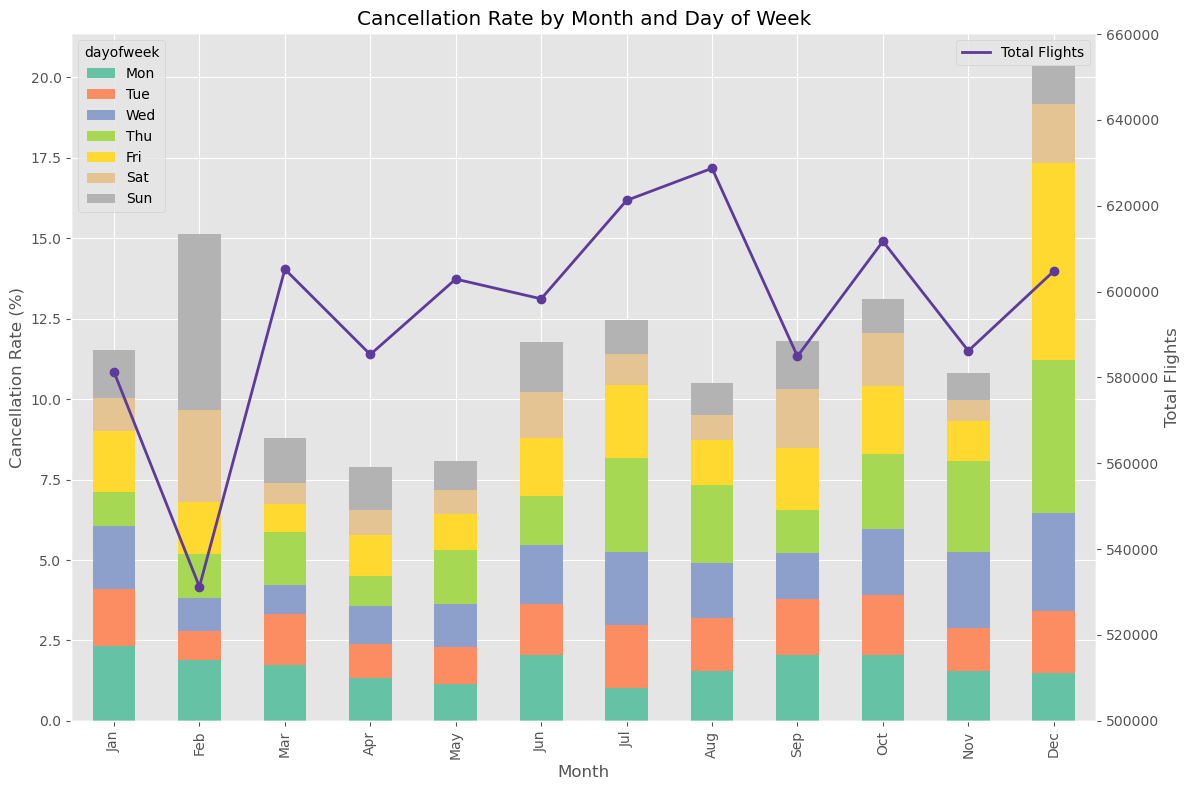

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create pivot table for cancellation rate by month and day of week
df9['cancel_rate'] = df9['cancellation_count'] / df9['total_flights'] * 100
pivot_df = df9.pivot_table(index='month', columns='dayofweek', values='cancel_rate', fill_value=0)
pivot_df = pivot_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

# Ensure the index is 1-12 for months
pivot_df.index = list(range(1, 13))

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot Stacked bar chart
bars = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set2', ax=ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Cancellation Rate (%)')
ax1.set_title('Cancellation Rate by Month and Day of Week')

# Create a second y-axis for total flights
ax2 = ax1.twinx()

# This is the key fix: We need to use the x-positions of the bars for the line plot
x_positions = np.arange(len(pivot_df.index))  # Get bar positions (0-11)

# Ensure df8 is properly aligned with the same months (1-12)
# Match df8's data to the bar positions
total_flights_data = []
for month in range(1, 13):
    if month in df8['month'].values:
        total_flights_data.append(df8.loc[df8['month'] == month, 'total_flights'].values[0])
    else:
        total_flights_data.append(0) 

# Plot the line using the bar positions
ax2.plot(x_positions, total_flights_data, color='#5D3A9B', marker='o', label='Total Flights', linewidth=2)
ax2.set_ylim(500000, max(total_flights_data) * 1.05)
ax2.set_ylabel('Total Flights')

# Create combined legend
legend_elements = [plt.Line2D([0], [0], color='#5D3A9B', lw=2, label='Total Flights')]
ax2.legend(handles=legend_elements, loc='upper right')

# Set x-tick labels to month names
ax1.set_xticks(x_positions)
ax1.set_xticklabels(month_labels)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

This visualization shows the **monthly cancellation rate (%) by day of the week** alongside the **total number of flights per month**. The stacked bars represent the cancellation rate for each **day of the week (Mon–Sun)**, color-coded accordingly. The **purple line** overlays the total flight volume each month. Notably, **February** has among the **highest cancellation rate** despite a **lowest total flight volume**, while **December** experiences the **highest cancellation rate**, particularly driven by **Fridays and Thursdays**. This pattern may reflect holiday travel disruptions, including winter weather or high passenger demand. Months like **July and August** also show elevated cancellation rates despite moderate flight volumes, possibly influenced by summer travel congestion. Weekday-wise, **Friday and Sunday cancellations** are consistently higher across multiple months, suggesting that flights closer to the weekend may be more vulnerable to cancellations, potentially due to higher operational pressures or peak travel periods. This insight could help travelers plan more reliable travel dates and times.


In [70]:
query10 = '''
SELECT
    DayofMonth,
    CASE
        WHEN DayOfWeek = 1 THEN 'Mon'
        WHEN DayOfWeek = 2 THEN 'Tue'
        WHEN DayOfWeek = 3 THEN 'Wed'
        WHEN DayOfWeek = 4 THEN 'Thu'
        WHEN DayOfWeek = 5 THEN 'Fri'
        WHEN DayOfWeek = 6 THEN 'Sat'
        WHEN DayOfWeek = 7 THEN 'Sun'
    END AS DayOfWeek,
	SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
	COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
WHERE Month = 4
GROUP BY DayofMonth, DayOfWeek
ORDER BY DayofMonth, DayOfWeek ASC
'''
df10 = pull_data(query10)
df10

,dayofmonth,dayofweek,cancellation_count,total_flights,cancellation_rate_pct
0,1,Sat,149,17207,0.87
1,2,Sun,328,19214,1.71
2,3,Mon,527,20264,2.60
3,4,Tue,357,19693,1.81
4,5,Wed,276,20087,1.37
5,6,Thu,210,20325,1.03
6,7,Fri,366,20349,1.80
7,8,Sat,159,17338,0.92
8,9,Sun,106,19307,0.55
9,10,Mon,127,20285,0.63


##### Day

From the graph above, we have identified that April has the lowest cancellation rates despite a moderate travel volume. Thus, we can narrow down our analysis into April to look into patterns across the month.

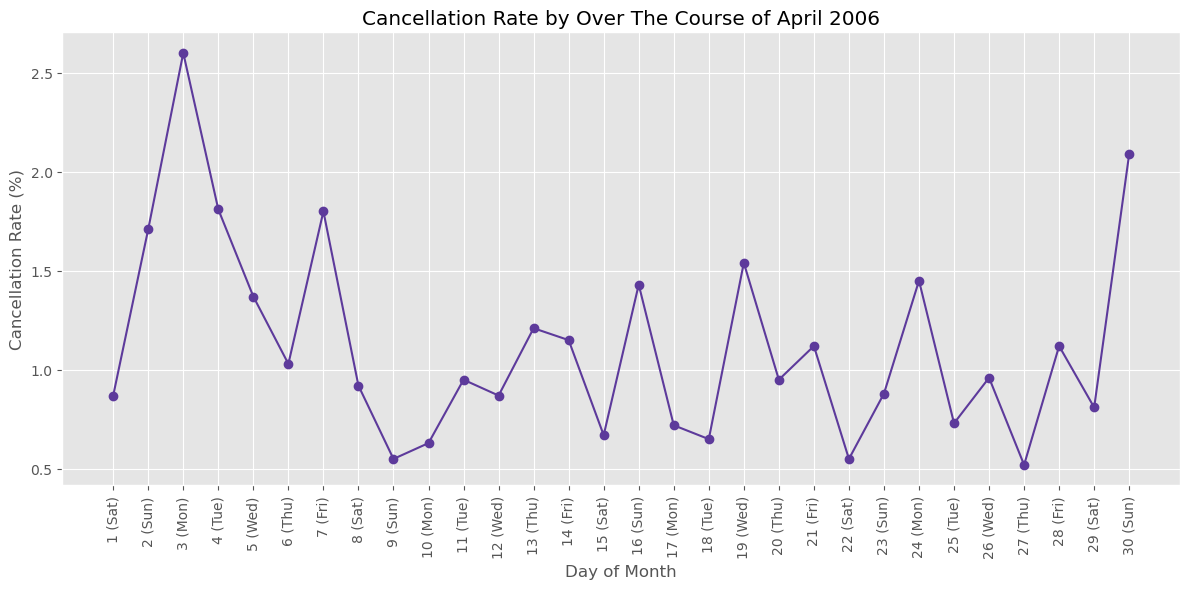

In [72]:
temp = df10.copy() # Create a temporary copy of df10 to plot

# Plot the day of month vs cancellation rate
plt.figure(figsize=(12, 6))
plt.plot(temp['dayofmonth'], temp['cancellation_rate_pct'], marker='o', color='#5D3A9B')


# Get the x-positions (days of month)
x_positions = temp['dayofmonth']


day_labels = temp['dayofweek']

# Get the corresponding day of week labels
for index, label in zip(x_positions, df10['dayofweek']):
    day_labels[index-1] = f"{index} ({label})"

plt.xlabel('Day of Month')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by Over The Course of April 2006')
plt.xticks(ticks=x_positions, labels=day_labels, rotation=90)
plt.tight_layout()
plt.show()

Consistent with our earlier observations, **cancellation rates tend to increase as the week progresses toward the weekend**, with Thursdays and Fridays showing the highest spikes. This pattern likely reflects the buildup of travel demand and operational pressures as more passengers plan weekend trips. Despite these midweek surges, **cancellation rates remain relatively stable throughout the month**, except for noticeable increases at the very beginning and end of each month that may coincide with payroll cycles, scheduling changes, or other operational factors.

Interestingly, **weekends show significantly lower cancellation rates**. This suggests that despite higher overall travel volumes during weekends, airlines may better manage operations or prioritize flights, resulting in fewer cancellations. For travelers looking to minimize the risk of cancellations, flying on weekends could be a smarter choice.

##### Time

Again, the analysis can be further narrowed down more. We have so far identified the best month to travel is in April, and best day to travel is on a Saturday. Thus, we look further into Saturday on what time is the best to travel to avoid flight cancellations.

In [217]:
# April, Saturday
query11 = '''
SELECT
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
    ELSE 'Unknown'
  END AS crsdeptime,
  SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
  COUNT(*) AS total_flights,
  ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM data
WHERE
  Month = 4 AND DayOfWeek = 6
GROUP BY
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    WHEN (CRSDepTime >= 2100 AND CRSDepTime <= 2359) OR (CRSDepTime >= 0 AND CRSDepTime < 500) THEN 'Night'
    ELSE 'Unknown'
  END
ORDER BY crsdeptime
'''

df11 = pull_data(query11)
df11

,crsdeptime,cancellation_count,total_flights,cancellation_rate_pct
0,Afternoon,220,28154,0.78
1,Evening,89,17861,0.50
2,Morning,333,36469,0.91
3,Night,18,4003,0.45


In [ ]:
# Reorder the time of day 
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df11 = df11.groupby('crsdeptime', observed=True).agg(
    cancellation_count=('cancellation_count', 'mean'),
    total_flights=('total_flights', 'mean'),
    cancellation_rate_pct=('cancellation_rate_pct', 'mean')
).reindex(time_order)

In [219]:
df11

,cancellation_count,total_flights,cancellation_rate_pct
crsdeptime,,,
Morning,333.0,36469.0,0.91
Afternoon,220.0,28154.0,0.78
Evening,89.0,17861.0,0.50
Night,18.0,4003.0,0.45


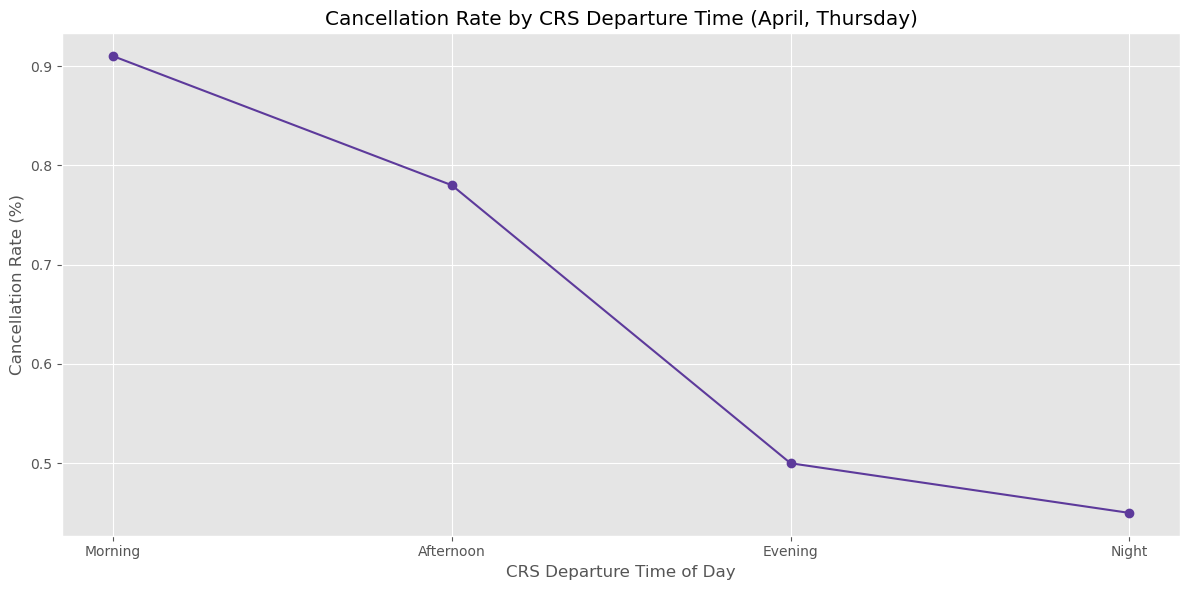

In [220]:
# Plot the crsdep time vs cancellation rate
plt.figure(figsize=(12, 6))
plt.plot(df11.index, df11['cancellation_rate_pct'], marker='o', color='#5D3A9B')

plt.xlabel('CRS Departure Time of Day')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by CRS Departure Time (April, Thursday)')
plt.tight_layout()
plt.show()

Overall, the **cancellation rates for these flights remain relatively low throughout the day**, indicating generally **stable operations**. Even during the morning hours which is typically one of the busiest times for air travel, the highest observed cancellation rate is still under 1%, which suggests that airlines are generally able to maintain their schedules despite the increased volume. This could reflect better preparedness or higher prioritization for morning departures.

Interestingly, **cancellation rates during the night are almost negligible**, approaching 0%. This may be due to several factors. Nighttime flight schedules are often less congested, allowing more flexibility in operations and reducing the risk of cascading delays from earlier flights. Additionally, fewer scheduled departures at night mean that airlines may have more capacity to accommodate any potential disruptions without needing to cancel flights altogether.

This pattern suggests that, while cancellations do occur, they are rare and more likely during peak hours rather than off-peak times. It also highlights the operational advantage of less crowded night-time schedules in maintaining flight reliability.

## 4. Problematic Routes

### Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.

We have to first define poor performance. In terms of airline industry;

1. High Cancellation Rates
2. High Delay Time (>15min from scheduled time)

In [79]:
query12 = '''
SELECT *
FROM (
    SELECT
        d.Origin,
        d.Dest,
        c.Description AS Description,
        d.FlightNum AS FlightNumber,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS cancellation_count,
        ROUND(100.0 * SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate_pct,
        AVG(ArrDelay) AS avg_arrival_delay,
        AVG(DepDelay) AS avg_departure_delay
    FROM data d
    LEFT JOIN
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY d.Origin, d.Dest, c.Description, d.FlightNum
    HAVING COUNT(*) >= 100 -- filter out low-volume routes
) AS route_stats
WHERE avg_arrival_delay > 15 OR avg_departure_delay > 15 
ORDER BY cancel_rate_pct DESC, avg_arrival_delay DESC, avg_departure_delay DESC
LIMIT 20
'''
df12 = pull_data(query12)
df12

,origin,dest,description,flightnumber,total_flights,cancellation_count,cancel_rate_pct,avg_arrival_delay,avg_departure_delay
0,LGA,CVG,Comair Inc.,5166,174,40,22.99,37.365672,44.641791
1,MSN,ORD,Skywest Airlines Inc.,6876,179,39,21.79,22.578571,22.992857
2,CVG,EWR,Expressjet Airlines Inc.,3272,161,35,21.74,31.341270,33.833333
3,PIT,EWR,Expressjet Airlines Inc.,2943,200,42,21.00,51.784810,48.202532
4,MSP,EWR,Expressjet Airlines Inc.,2947,153,32,20.92,29.075630,30.173554
5,ORD,MSN,Skywest Airlines Inc.,6876,173,36,20.81,16.678832,18.656934
6,ORD,MBS,Skywest Airlines Inc.,6854,101,21,20.79,15.262500,20.162500
7,ROC,EWR,Expressjet Airlines Inc.,2065,280,57,20.36,35.614350,37.165919
8,GSP,EWR,Expressjet Airlines Inc.,2737,167,34,20.36,22.800000,28.436090
9,BWI,EWR,Expressjet Airlines Inc.,2491,360,73,20.28,39.979021,31.118467


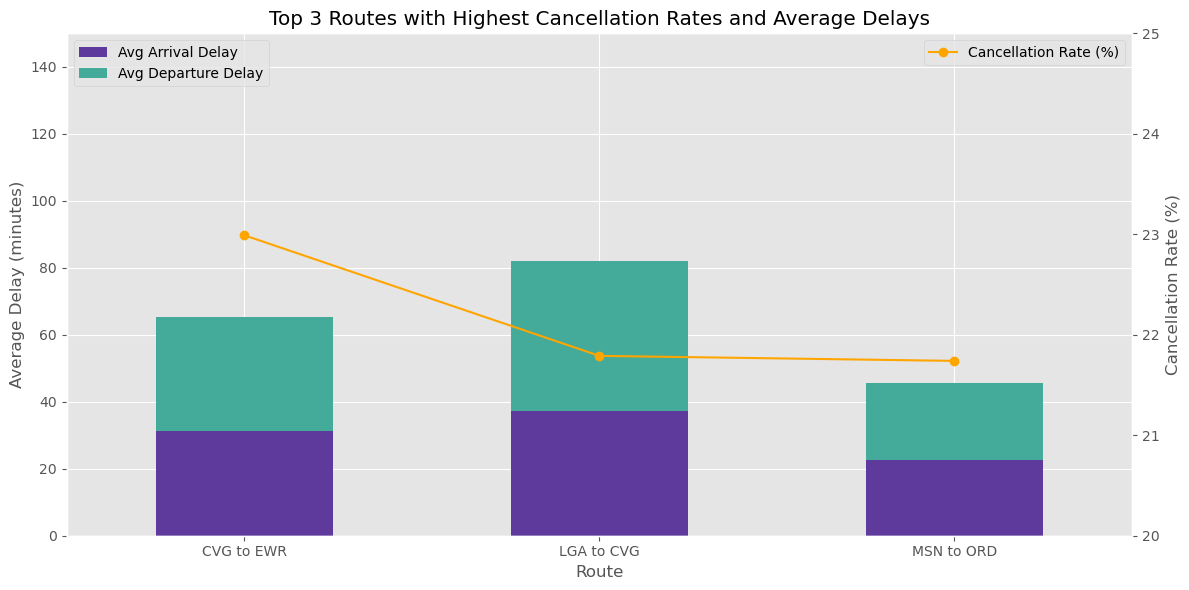

In [222]:
top5_poor_routes = df12.head(3)

# Add a new column for the route
top5_poor_routes['route'] = top5_poor_routes['origin'] + ' to ' + top5_poor_routes['dest']

# Create pivot table for delay type and average delay
delay_pivot = top5_poor_routes.pivot_table(index='route', values=['avg_arrival_delay', 'avg_departure_delay'], aggfunc='mean')

# Plot the top flights with highest cancellation rates
fig, ax1 = plt.subplots(figsize=(12, 6))
delay_pivot.plot(kind='bar', ax=ax1, color=['#5D3A9B', '#44AA99'], stacked=True)
ax1.set_ylim(0, 150)
ax1.set_xlabel('Route')
ax1.set_ylabel('Average Delay (minutes)')
ax1.set_title('Top 3 Routes with Highest Cancellation Rates and Average Delays')
ax1.set_xticklabels(delay_pivot.index, rotation=0)
ax1.legend(['Avg Arrival Delay', 'Avg Departure Delay'], loc='upper left')

ax2 = ax1.twinx()

ax2.plot(top5_poor_routes['route'], top5_poor_routes['cancel_rate_pct'], color='orange', marker='o', label='Cancellation Rate (%)')
ax2.set_ylabel('Cancellation Rate (%)')
ax2.set_ylim(20, 25)
ax2.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()

From the graph above, the top 3 worst performing flight routes can be seen. 

CVG - EWR : Cincinnati Northern Kentucky Intl to Newark Intl <br>
LGA - CVG : LaGuardia to Cincinnati Northern Kentucky Intl <br>
MSN - ORD : Dane County Regional to Chicago O'Hare International


**CVG - EWR showed highest cancellation rate of 23%** of flights with even average delay for both arrival and destination flights. LGA to CVG has similar cancellation rate to MSN to ORD despite having the highest delays for both arrival and destination flights.


### Analyse the reasons these particular flights are prone to delays or cancellations.

#### Plane Performance

Once problematic routes have been identified, deeper insights can be gained by further driling into the data. Questions such as; "Which aricraft is causing these problems?" or "What is causing all these delays in these poor performing airports?" can be answered. We aim to first describe the aircraft usage within the top 3 routes. 

In [116]:
query13 = '''
SELECT 
	CONCAT(d.Origin, '-', d.Dest) AS routes,
	d.FlightNum,
	d.TailNum,
	p.Type,
	p.Manufacturer,
	p.Issue_date,
	p.Model,
	p.Aircraft_Type,
	p.Engine_Type,
	p.Year
FROM data d
LEFT JOIN 
	plane_data p ON d.TailNum = p.TailNum
WHERE 
	(d.Origin, d.Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR')) AND d.FlightNum IN ('5166','6876','3272')
'''

df13 = pull_data(query13)
df13

,routes,flightnum,tailnum,type,manufacturer,issue_date,model,aircraft_type,engine_type,year
0,MSN-ORD,6876,N924SW,Corporation,BOMBARDIER INC,10/18/2003,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2002
1,MSN-ORD,6876,N917SW,Corporation,BOMBARDIER INC,05/03/2002,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,None
2,MSN-ORD,6876,N406SW,Corporation,CANADAIR,06/30/2008,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Jet,1993
3,MSN-ORD,6876,N969SW,Corporation,BOMBARDIER INC,01/05/2004,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2003
4,MSN-ORD,6876,N961SW,Corporation,BOMBARDIER INC,10/23/2003,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2003
...,...,...,...,...,...,...,...,...,...,...
509,LGA-CVG,5166,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Jet,1998
510,LGA-CVG,5166,N986CA,Corporation,CANADAIR,02/04/2008,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Jet,None
511,LGA-CVG,5166,N786CA,Corporation,BOMBARDIER INC,12/07/2007,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,1999
512,LGA-CVG,5166,N420CA,Corporation,BOMBARDIER INC,11/29/2007,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2000


In [119]:
df13.dropna(inplace=True)
df13['issue_date'] = pd.to_datetime(df13['issue_date'])
df13['year'] = df13['issue_date'].dt.year

In [142]:
df13[df13['year'] >= 2006].head(3)

,routes,flightnum,tailnum,type,manufacturer,issue_date,model,aircraft_type,engine_type,year
2,MSN-ORD,6876,N406SW,Corporation,CANADAIR,2008-06-30,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Jet,2008
30,MSN-ORD,6876,N406SW,Corporation,CANADAIR,2008-06-30,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Jet,2008
67,LGA-CVG,5166,N814CA,Corporation,BOMBARDIER INC,2007-12-11,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2007


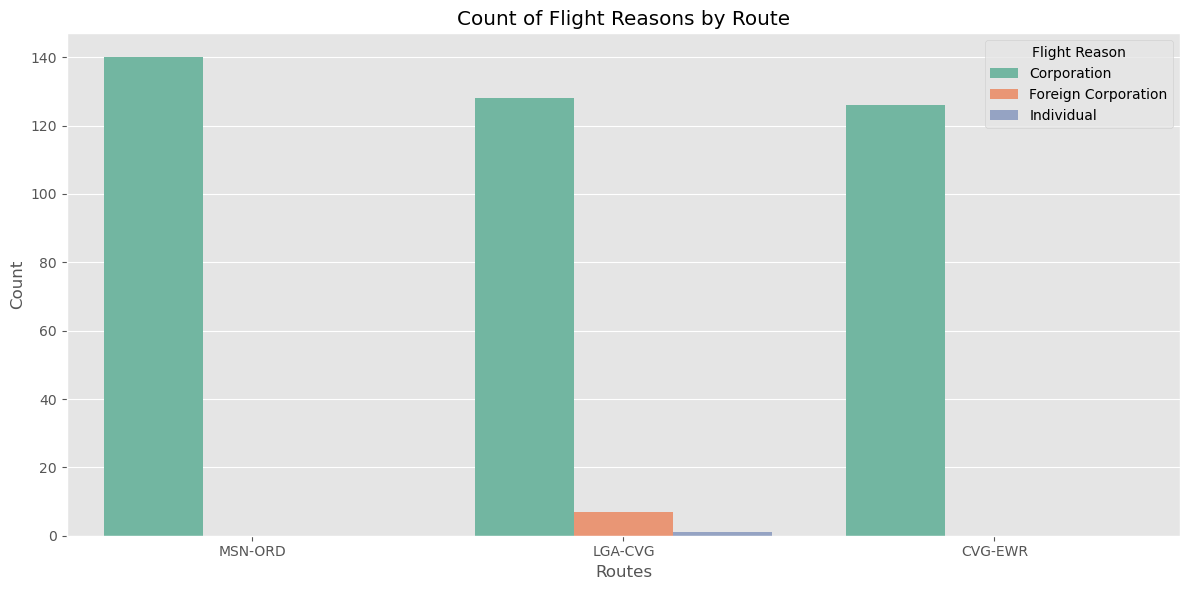

In [234]:
# Plot type
plt.figure(figsize=(12, 6))
sns.countplot(data=df13, x='routes', hue='type', palette='Set2')
plt.title('Count of Flight Reasons by Route')
plt.legend(title='Flight Reason', loc='upper right')
plt.xlabel('Routes')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


This bar chart shows the main reasons people travel on the three routes with known performance issues: 'MSN-ORD', 'LGA-CVG', and 'CVG-EWR'. Across all three, the **majority of passengers are traveling for business purposes**, while only a small portion are flying for personal reasons. This trend is consistent on each route, suggesting that these flights are mainly used by business travelers. Since **business travelers usually fly during peak hours and have stricter schedules**, these **routes might be more sensitive to delays or disruptions**, which could add pressure to airline and airport operations. It also means that improving reliability on these routes could be especially important, as delays may have a bigger impact on passengers' professional commitments.


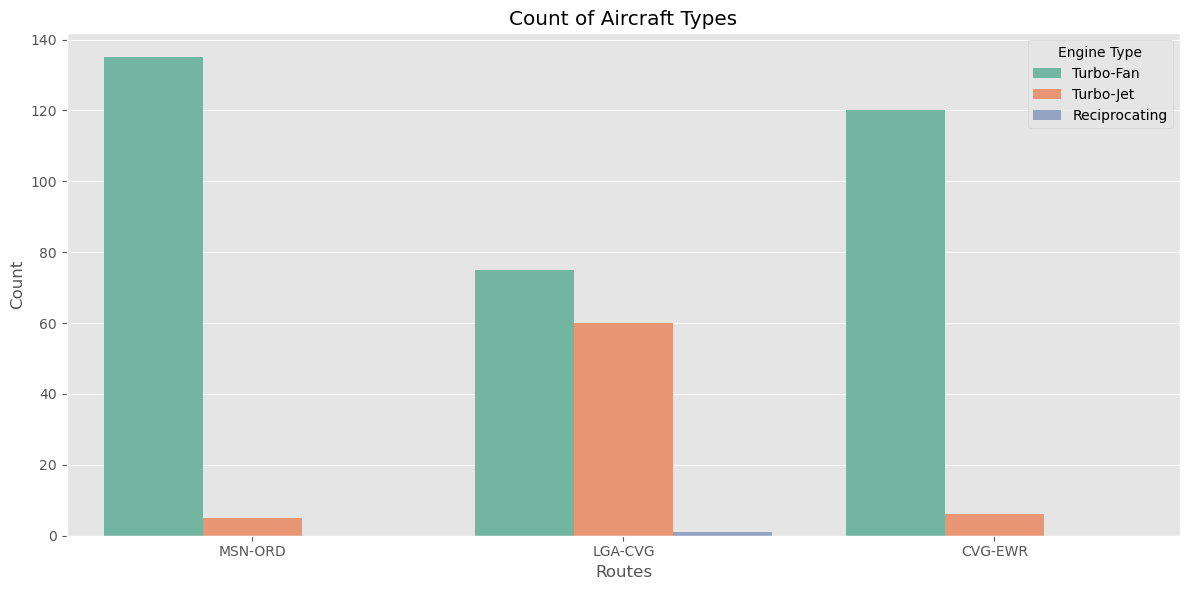

In [233]:
# Plot aircraft type
plt.figure(figsize=(12, 6))
sns.countplot(data=df13, x='routes', hue='engine_type', palette='Set2')
plt.legend(title='Engine Type', loc='upper right')
plt.title('Count of Aircraft Types')
plt.xlabel('Routes')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Across all routes, **Turbo-Fan engines are the most common**. These engines are widely used in modern commercial planes because they are fuel-efficient, quieter, and provide strong thrust, making them suitable for most flights. Turbo-Jet engines are seen much less often as they are older, noisier, and use more fuel, though they are fast and still found in some older or specialized aircraft. Reciprocating engines are rare in this dataset, as they are typically used in small private planes and are not practical for commercial flights due to their lower power and efficiency.

**Even though these routes are known to perform poorly (e.g., frequent delays or cancellations), the engine type is likely not the reason.** 

Instead, the problems may come from other issues. For example, these routes connect smaller or busier airports like Dane County Regional, LaGuardia, Cincinnati/Northern Kentucky, and Newark Liberty, which may face air traffic congestion, outdated systems, or limited capacity. These regional routes can also be more affected by bad weather, have tighter schedules, or be served by smaller carriers with fewer backup options when things go wrong. Airport facilities like gates and ground services might also be limited. Additionally, the airlines themselves could face staff shortages or maintenance issues. So, while the aircraft and engines are suitable, the poor performance is probably due to a mix of air traffic, weather, and operational challenges specific to these routes and not the engines themselves.

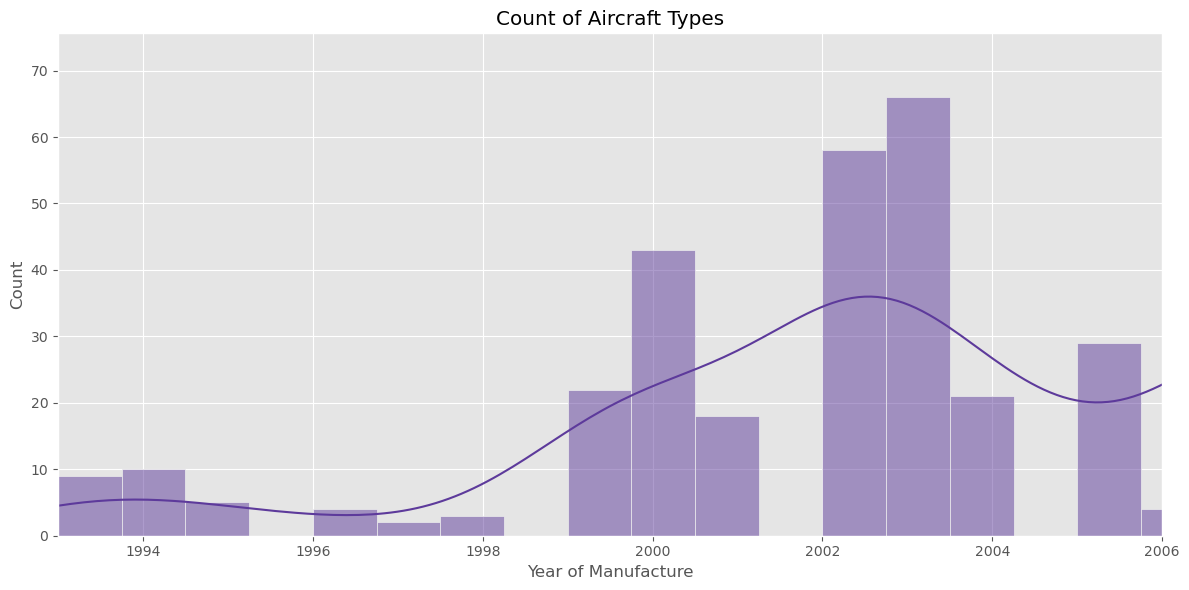

In [145]:
# Plot year of manufacture
plt.figure(figsize=(12, 6))
sns.histplot(data=df13, x='year', bins=20, kde=True, color='#5D3A9B')
plt.title('Count of Aircraft Types')
plt.xlabel('Year of Manufacture')
plt.xlim(df13['year'].min(), 2006)
plt.ylabel('Count')
plt.tight_layout()
plt.show()


The chart showing the year of manufacture for aircraft on the 'MSN-ORD', 'LGA-CVG', and 'CVG-EWR' routes reveals that **most planes are relatively new**. This suggests that aircraft age is likely not the main reason for performance issues on these routes. **Newer planes are generally more reliable, efficient, and less prone to mechanical problems**. 

Therefore, the underperformance seen on these routes based on the condition of the aircrafts used in these routes, is probably due to other factors such as airport congestion, weather disruptions, scheduling issues, or operational delays rather than the condition or age of the aircraft themselves.


#### Delay Reasons

In [ ]:
query15 = '''
SELECT
  CONCAT(Origin, '-', Dest) AS routes,
  DelayType,
  AVG(AvgDelayMinutes) AS AvgDelayMinutes,
  SUM(IncidentCount) AS IncidentCount
FROM (
  SELECT Origin, Dest, 'CarrierDelay' AS DelayType,
         AVG(CarrierDelay) AS AvgDelayMinutes,
         COUNT(*) AS IncidentCount
  FROM data
  WHERE 
       CarrierDelay > 0
       AND (Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'WeatherDelay',
         AVG(WeatherDelay),
         COUNT(*)
  FROM data
  WHERE WeatherDelay > 0
       AND (Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'NASDelay',
         AVG(NASDelay),
         COUNT(*)
  FROM data
  WHERE NASDelay > 0
       AND (Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'SecurityDelay',
         AVG(SecurityDelay),
         COUNT(*)
  FROM data
  WHERE SecurityDelay > 0
       AND (Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'LateAircraftDelay',
         AVG(LateAircraftDelay),
         COUNT(*)
  FROM data
  WHERE LateAircraftDelay > 0
       AND (Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
  GROUP BY Origin, Dest
) AS DelaySummary
GROUP BY CONCAT(Origin, '-', Dest), DelayType
ORDER BY AvgDelayMinutes DESC
'''

df15 = pull_data(query15)
df15

,routes,delaytype,avgdelayminutes,incidentcount
0,MSN-ORD,NASDelay,106.354839,31
1,MSN-ORD,WeatherDelay,98.000000,1
2,LGA-CVG,WeatherDelay,84.200000,25
3,LGA-CVG,LateAircraftDelay,80.100000,10
4,LGA-CVG,CarrierDelay,71.931034,29
5,MSN-ORD,LateAircraftDelay,67.833333,6
6,CVG-EWR,NASDelay,63.032258,62
7,CVG-EWR,LateAircraftDelay,46.315789,19
8,CVG-EWR,WeatherDelay,36.500000,2
9,MSN-ORD,CarrierDelay,31.666667,9


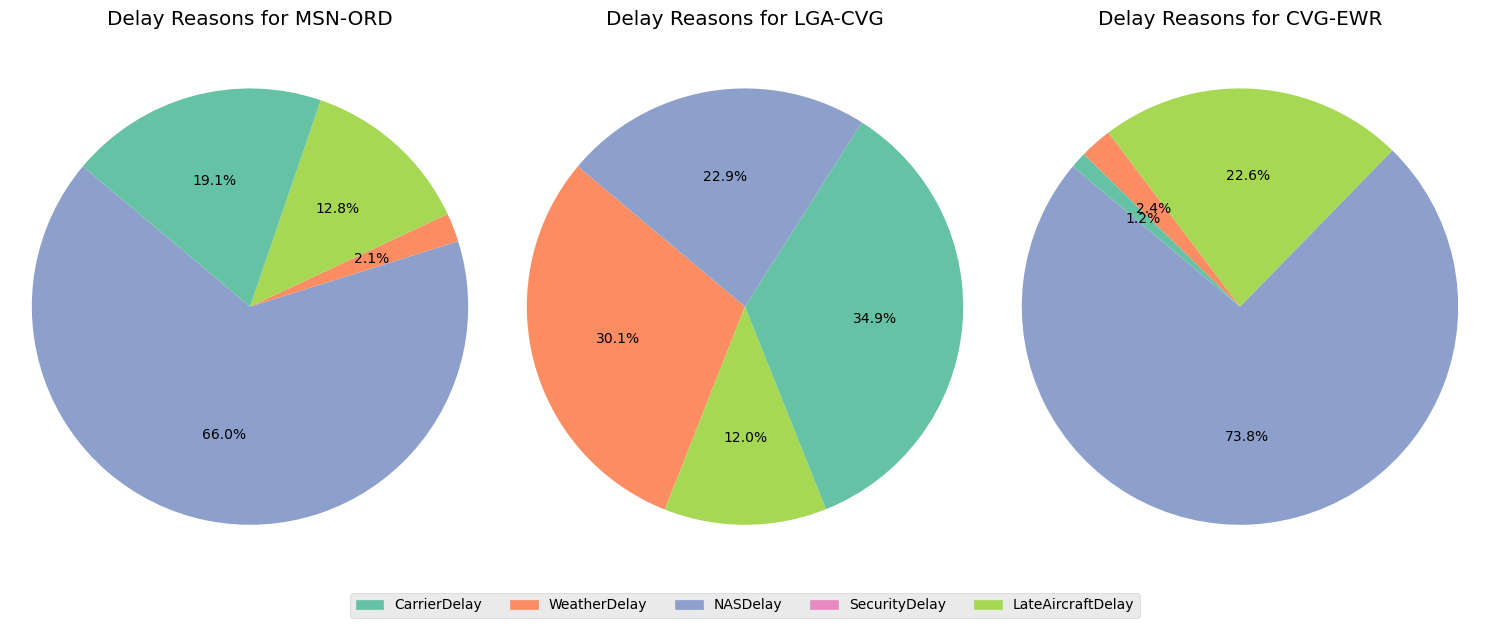

In [ ]:
# Define delay reasons and assign Set2 colors
delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
set2_palette = sns.color_palette("Set2", n_colors=len(delay_reasons))
color_map = dict(zip(delay_reasons, set2_palette))

# Unique routes
unique_routes = df15['routes'].unique()

# Create subplots (1 row, as many columns as there are unique routes)
fig, ax = plt.subplots(figsize=(5 * len(unique_routes), 6), ncols=len(unique_routes), nrows=1)

# Plot pie chart for each route
for i, route in enumerate(unique_routes):
    route_data = df15[df15['routes'] == route]
    labels = route_data['delaytype']
    sizes = route_data['incidentcount']
    
    # Get colors for each label
    colors = [color_map.get(label, '#CCCCCC') for label in labels]
    
    ax[i].pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140)
    ax[i].set_title(f'Delay Reasons for {route}')
    ax[i].axis('equal')  # Equal aspect ratio for circle

# Add a legend below the plots
legend_patches = [Patch(color=color_map[reason], label=reason) for reason in delay_reasons]
fig.legend(handles=legend_patches, loc='lower center', ncol=len(delay_reasons), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

A closer look reveals that **Late Aircraft Delays** and **Carrier Delays** are not only among the **most common causes across multiple routes** but are also **associated with relatively high average delay durations** (known from the analysis above, Delay Factors). This suggests that when these delays occur, **they tend to be more disruptive and harder to recover from**, likely due to cascading effects such as late arrivals impacting turnaround times and subsequent flight schedules. In contrast, although **NAS Delays** and **Security Delays** do appear in the charts, **it contributes far less both in frequency and in terms of average delay minutes**. This implies that while these issues may occasionally arise, they tend to be resolved more quickly or have less operational impact on overall flight performance.

**Weather Delays** also stand out, particularly on certain routes, as they contribute to **fewer total incidents compared to Carrier or Late Aircraft delays but tend to cause longer delays on average**. This makes weather an especially challenging factor, as it is unpredictable and often unavoidable, requiring significant buffer time and contingency planning.

Overall, the combination of incident frequency and delay duration paints a more complete picture of route performance. While Carrier and Late Aircraft Delays should be closely monitored due to their operational weight, special attention should also be given to weather-affected routes for proactive mitigation. On the other hand, although NAS and Security Delays are present, their relatively lower impact suggests that efforts to improve performance might yield greater returns if focused on the more delay-intensive categories.

#### Cancellation Reasons

In [146]:
query14 = '''
SELECT
	CONCAT(Origin, '-', Dest) AS routes,
	CASE
		WHEN CancellationCode = "A" THEN "Carrier"
		WHEN CancellationCode = "B" THEN "Weather"
		WHEN CancellationCode = "C" THEN "NAS"
		WHEN CancellationCode = "D" THEN "Security"
		ELSE "Unknown"
	END AS cancellation_code,
	SUM(Cancelled) AS count_cancellation
FROM data
WHERE
	(Origin, Dest) IN (('LGA', 'CVG'), ('MSN', 'ORD'), ('CVG', 'EWR'))
	AND FlightNum IN ('5166','6876','3272')
	AND Cancelled = 1
GROUP BY CONCAT(Origin, '-', Dest), CancellationCode
ORDER BY count_cancellation DESC
'''

df14 = pull_data(query14)
df14

,routes,cancellation_code,count_cancellation
0,MSN-ORD,NAS,34
1,CVG-EWR,NAS,30
2,LGA-CVG,Weather,21
3,LGA-CVG,Carrier,15
4,CVG-EWR,Weather,4
5,LGA-CVG,NAS,4
6,MSN-ORD,Weather,3
7,MSN-ORD,Carrier,2
8,CVG-EWR,Carrier,1


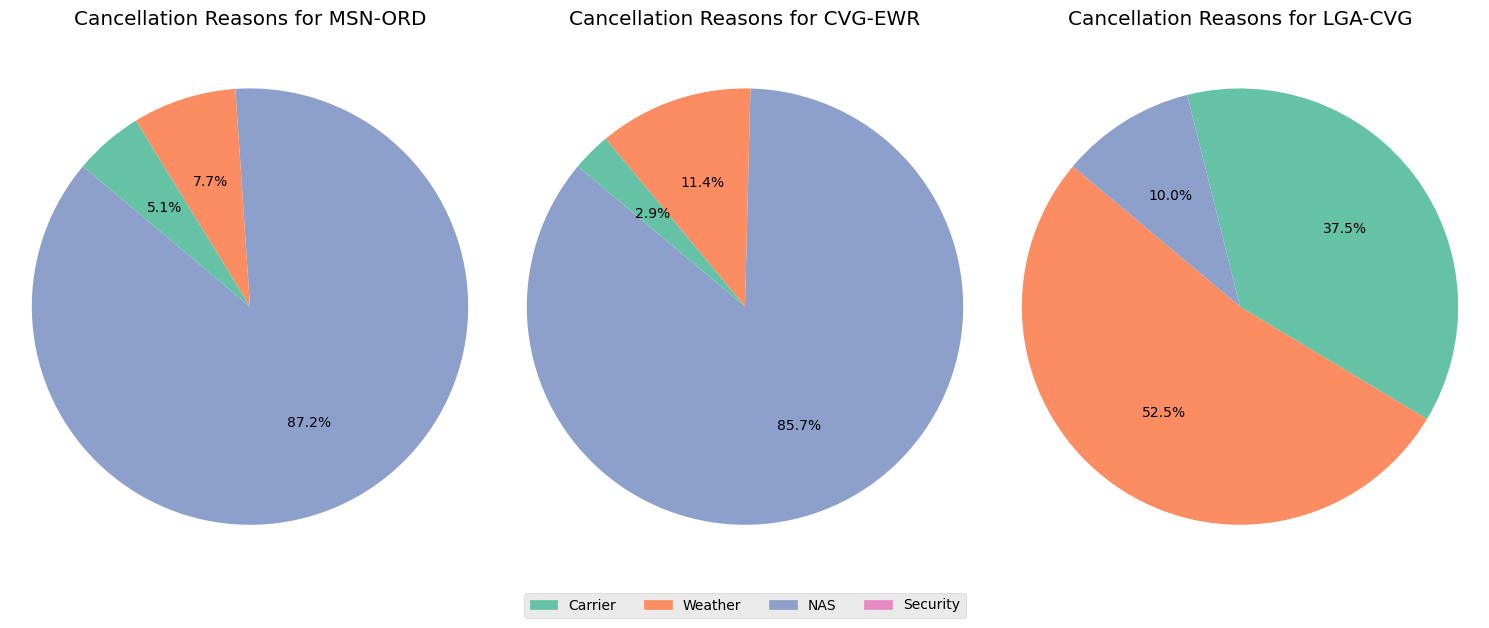

In [162]:
# Define cancellation reasons and assign Set2 colors
cancel_reasons = ['Carrier', 'Weather', 'NAS', 'Security']
set2_palette = sns.color_palette("Set2", n_colors=len(cancel_reasons))
color_map = dict(zip(cancel_reasons, set2_palette))

# Create subplots
fig, ax = plt.subplots(figsize=(15, 6), ncols=3, nrows=1)

# Plot pie charts for each route
for i, route in enumerate(df14['routes'].unique()):
    route_data = df14[df14['routes'] == route]
    labels = route_data['cancellation_code']
    sizes = route_data['count_cancellation']
    
    # Get colors for each label
    colors = [color_map.get(label, '#CCCCCC') for label in labels]
    
    ax[i].pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140)
    ax[i].set_title(f'Cancellation Reasons for {route}')
    ax[i].axis('equal')

# Add a legend below the plots
legend_patches = [Patch(color=color_map[reason], label=reason) for reason in cancel_reasons]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

The routes **'MSN-ORD' and 'CVG-EWR'** show a **high proportion of cancellations due to NAS (National Aviation System) issues**, 87.2% and 85.7% respectively. These typically involve air traffic control delays, airport congestion, or other system-level disruptions that are beyond the airline’s direct control. This suggests that infrastructure and national-level operational constraints play a major role in the performance issues on these routes.

In contrast, the **'LGA-CVG'** route has a very different pattern. Here, **over half (52.5%) of the cancellations are due to carrier-related issues** such as staffing, maintenance problems, or scheduling disruptions. Weather also contributes significantly (37.5%), indicating that this route is particularly sensitive to both internal airline operations and adverse weather conditions.

In summary, the poor performance of these routes is driven by different factors: infrastructure and airspace challenges for 'MSN-ORD' and 'CVG-EWR', and airline-specific and weather-related issues for 'LGA-CVG'. Understanding these patterns is key to addressing delays and improving reliability on each route.

## Conclusion

The comprehensive analysis of flight delays and cancellations reveals several consistent and insightful patterns across time, causes, airlines, airports, and specific routes. Departure delays tend to be more severe than arrival delays, likely due to late-arriving aircraft, extended ground operations, and congestion during take-off. Delays are minimal during morning hours when daily operations begin fresh but accumulate as the day progresses, peaking in the late afternoon and evening because of cascading effects from earlier disruptions and increased traffic. Tuesday mornings and spring months generally show the least delays, reflecting lower travel demand and smoother operations, while Thursdays, Fridays, and peak travel months like June and December experience the highest delays due to increased passenger volume and holiday travel.

When analyzing the causes, NAS (National Airspace System) delays are the most frequent but relatively short, whereas weather delays, though infrequent, cause the longest disruptions. Carrier-related issues dominate flight cancellations, followed by weather and NAS-related factors. Statistical testing confirms significant differences in cancellation rates between top 5 airlines with poor cancellation rate and others, as well as among certain airports with persistently high cancellation rates such as Telluride Regional and Hickory Municipal. Cancellation rates increase toward the end of the workweek, especially on Thursdays and Fridays, but surprisingly decrease on weekends, suggesting more effective operational management during those periods. Nighttime cancellations are negligible, likely due to less congested schedules and greater operational flexibility.

Examining specific routes with poor performance; CVG to EWR, LGA to CVG, and MSN to ORD. These routes reveals high cancellation and delay rates, primarily affecting business travelers who depend on reliable schedules. The predominant use of modern turbo-fan aircraft and relatively new planes indicates that mechanical issues or aircraft age are not the main causes of poor performance. Instead, operational challenges such as airport congestion, scheduling constraints, weather disruptions, and airline-specific factors like staffing and maintenance are key contributors. On the CVG-EWR and MSN-ORD routes, cancellations are mostly due to NAS issues, reflecting systemic infrastructure and airspace challenges, whereas the LGA-CVG route struggles more with carrier and weather-related cancellations.

Overall, while frequent delay causes such as late aircraft and carrier delays tend to produce longer disruptions, NAS and security delays are less frequent and less impactful. Weather delays, although rarer, require special attention due to their unpredictability and severity. These findings emphasize the importance of maintaining morning operational efficiency to prevent delay accumulation, managing peak travel demand periods carefully, and addressing both airline-specific and system-wide issues to improve on-time performance and reduce cancellations. This multifaceted understanding can guide airlines, airports, and travelers alike in making informed decisions to optimize reliability and minimize disruption.
